# GrIS ablation zone melt SEB causality

Author: Ziqi Yin

Last modified: 2025 Sep 15

Description: Causal inference of Greenland Ice Sheet summer surface melt
- Method: PCMCI+
- Period: 2071-2100
- Frequency: monthly
- Region: ablation zone
- Variables: SWn, LWn, SH, LH
- Source: fully coupled CESM2 large ensemble 50 cmip6 members

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

import sys
home_dir = '/glade/work/ziqiyin/'
sys.path.insert(0, home_dir)
from copy import deepcopy

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore')

import tigramite
import tigramite.data_processing as pp
import tigramite.plotting as tp

from tigramite.models import LinearMediation, Models
from tigramite.causal_effects import CausalEffects

from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from tigramite.independence_tests.gpdc import GPDC
from tigramite.independence_tests.cmiknn import CMIknn
from tigramite.independence_tests.cmisymb import CMIsymb

import cartopy
import cartopy.crs as ccrs
from matplotlib.gridspec import GridSpec
from matplotlib.collections import PolyCollection
from collections import Counter, defaultdict

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/ziqiyin/conda-envs/my-npl-202306a/share/proj failed


In [2]:
# Function to remove seasonal mean and divide by seasonal standard deviation
def anomalize(dataseries, divide_by_std=True, reference_bounds=None, cycle_length=12, return_cycle=False):
    if reference_bounds is None:
        reference_bounds = (0, len(dataseries))

    anomaly = np.copy(dataseries)
    for t in range(cycle_length):
        if return_cycle:
            anomaly[t::cycle_length] = dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
        else:
            anomaly[t::cycle_length] -= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].mean(axis=0)
            if divide_by_std:
                anomaly[t::cycle_length] /= dataseries[t+reference_bounds[0]:reference_bounds[1]:cycle_length].std(axis=0)
    return anomaly

In [3]:
# Set Polar Sterographic Projection definition
polar_stereographic = ccrs.Stereographic(
    central_latitude=90.0,
    central_longitude=-45.0,
    false_easting=0.0,
    false_northing=0.0,
    true_scale_latitude=70.0,
    globe=ccrs.Globe('WGS84')
)

In [4]:
dates = pd.date_range("2045-01-01", periods=56*12, freq='M')

In [5]:
## Area
Re = 6371.22 * 1e3 #[m]

f09_mask_file3 = '/glade/p/cesmdata/cseg/inputdata/share/domains/domain.lnd.fv0.9x1.25_gx1v7.151020.nc'
f09_area = xr.open_dataset(f09_mask_file3)['area'] #[Radian2]
f09_area_Arctic = f09_area.where(f09_area.yc > 60).values * Re**2
f09_area = f09_area.values * Re**2

In [6]:
## Mask
# Generate Greenland mask
f09_mask_file1 = '/glade/work/aherring/grids/uniform-res/f09/clm_surfdata_5_0/surfdata_f09_hist_78pfts_CMIP6_simyr1850_c200429.nc'
f09_GrIS_mask0 = xr.open_dataset(f09_mask_file1)['GLACIER_REGION']
f09_GrIS_mask0 = xr.where(f09_GrIS_mask0==2, 1, np.nan)

# Land fraction of grid cell
f09_mask_file3 = '/glade/campaign/collections/cmip/CMIP6/timeseries-cmip6/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001/lnd/proc/tseries/month_1/b.e21.B1850G.f09_g17_gl4.CMIP6-1pctCO2to4x-withism.001.clm2.h0.RAIN.000101-005012.nc'
f09_land_frac = xr.open_dataset(f09_mask_file3)['landfrac'] #fraction of grid cell that is active

In [7]:
Melt_dataset = np.zeros((50,30*12))
SWn_dataset = np.zeros((50,30*12))
LWn_dataset = np.zeros((50,30*12))
SH_dataset = np.zeros((50,30*12))
LH_dataset = np.zeros((50,30*12))

## Read and calculate

In [8]:
data_dir = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/'

namelist = ['1001.001']#, '1021.002', '1041.003', '1061.004', '1081.005', '1101.006', '1121.007', '1141.008', '1161.009', '1181.010',
#            '1231.001', '1231.002', '1231.003', '1231.004', '1231.005', '1231.006', '1231.007', '1231.008', '1231.009', '1231.010',
#            '1251.001', '1251.002', '1251.003', '1251.004', '1251.005', '1251.006', '1251.007', '1251.008', '1251.009', '1251.010',
#            '1281.001', '1281.002', '1281.003', '1281.004', '1281.005', '1281.006', '1281.007', '1281.008', '1281.009', '1281.010',
#            '1301.001', '1301.002', '1301.003', '1301.004', '1301.005', '1301.006', '1301.007', '1301.008', '1301.009', '1301.010']
#period = ['201501-202412', '202501-203412', '203501-204412', '204501-205412', '205501-206412', '206501-207412', '207501-208412', '208501-209412', '209501-210012']
period = ['204501-205412', '205501-206412', '206501-207412', '207501-208412', '208501-209412', '209501-210012']

for index, num in enumerate(namelist):

    RAIN_monthly_list = []
    SNOW_monthly_list = []
    QICE_MELT_monthly_list = []
    QSNOMELT_monthly_list = []
    QFLX_EVAP_TOT_monthly_list = []
    QRUNOFF_monthly_list = []
    FSA_monthly_list = []
    FIRA_monthly_list = []
    FSH_monthly_list = []
    EFLX_LH_TOT_monthly_list = []
    PCT_LANDUNIT_monthly_list = []

    for j in period:
        RAIN_monthly_p = xr.open_dataset(data_dir+'RAIN/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.RAIN.'+j+'.nc')['RAIN'] #[mm/s]
        SNOW_monthly_p = xr.open_dataset(data_dir+'SNOW/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.SNOW.'+j+'.nc')['SNOW']
        QICE_MELT_monthly_p = xr.open_dataset(data_dir+'QICE_MELT/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.QICE_MELT.'+j+'.nc')['QICE_MELT']
        QSNOMELT_monthly_p = xr.open_dataset(data_dir+'QSNOMELT/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.QSNOMELT.'+j+'.nc')['QSNOMELT']
        QFLX_EVAP_TOT_monthly_p = xr.open_dataset(data_dir+'QFLX_EVAP_TOT/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.QFLX_EVAP_TOT.'+j+'.nc')['QFLX_EVAP_TOT']
        QRUNOFF_monthly_p = xr.open_dataset(data_dir+'QRUNOFF/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.QRUNOFF.'+j+'.nc')['QRUNOFF']
        FSA_monthly_p = xr.open_dataset(data_dir+'FSA/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.FSA.'+j+'.nc')['FSA']
        FIRA_monthly_p = xr.open_dataset(data_dir+'FIRA/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.FIRA.'+j+'.nc')['FIRA']
        FSH_monthly_p = xr.open_dataset(data_dir+'FSH/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.FSH.'+j+'.nc')['FSH']
        EFLX_LH_TOT_monthly_p = xr.open_dataset(data_dir+'EFLX_LH_TOT/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.EFLX_LH_TOT.'+j+'.nc')['EFLX_LH_TOT']
        PCT_LANDUNIT_monthly_p = xr.open_dataset(data_dir+'PCT_LANDUNIT/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.PCT_LANDUNIT.'+j+'.nc')['PCT_LANDUNIT'][:,3,:,:]

        RAIN_monthly_list.append(RAIN_monthly_p)
        SNOW_monthly_list.append(SNOW_monthly_p)
        QICE_MELT_monthly_list.append(QICE_MELT_monthly_p)
        QSNOMELT_monthly_list.append(QSNOMELT_monthly_p)
        QFLX_EVAP_TOT_monthly_list.append(QFLX_EVAP_TOT_monthly_p)
        QRUNOFF_monthly_list.append(QRUNOFF_monthly_p)
        FSA_monthly_list.append(FSA_monthly_p)
        FIRA_monthly_list.append(FIRA_monthly_p)
        FSH_monthly_list.append(FSH_monthly_p)
        EFLX_LH_TOT_monthly_list.append(EFLX_LH_TOT_monthly_p)
        PCT_LANDUNIT_monthly_list.append(PCT_LANDUNIT_monthly_p)

    RAIN_monthly = xr.concat(RAIN_monthly_list, dim='time')
    SNOW_monthly = xr.concat(SNOW_monthly_list, dim='time')
    QICE_MELT_monthly = xr.concat(QICE_MELT_monthly_list, dim='time')
    QSNOMELT_monthly = xr.concat(QSNOMELT_monthly_list, dim='time')
    QFLX_EVAP_TOT_monthly = xr.concat(QFLX_EVAP_TOT_monthly_list, dim='time')
    QRUNOFF_monthly = xr.concat(QRUNOFF_monthly_list, dim='time')
    FSA_monthly = xr.concat(FSA_monthly_list, dim='time')
    FIRA_monthly = xr.concat(FIRA_monthly_list, dim='time')
    FSH_monthly = xr.concat(FSH_monthly_list, dim='time')
    EFLX_LH_TOT_monthly = xr.concat(EFLX_LH_TOT_monthly_list, dim='time')
    PCT_LANDUNIT_monthly = xr.concat(PCT_LANDUNIT_monthly_list, dim='time')

    RAIN_monthly['time'] = dates
    SNOW_monthly['time'] = dates
    QICE_MELT_monthly['time'] = dates
    QSNOMELT_monthly['time'] = dates
    QFLX_EVAP_TOT_monthly['time'] = dates
    QRUNOFF_monthly['time'] = dates
    FSA_monthly['time'] = dates
    FIRA_monthly['time'] = dates
    FSH_monthly['time'] = dates
    EFLX_LH_TOT_monthly['time'] = dates
    PCT_LANDUNIT_monthly['time'] = dates

    RAIN_monthly = RAIN_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    SNOW_monthly = SNOW_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    QICE_MELT_monthly = QICE_MELT_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    QSNOMELT_monthly = QSNOMELT_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    QFLX_EVAP_TOT_monthly = QFLX_EVAP_TOT_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    QRUNOFF_monthly = QRUNOFF_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    FSA_monthly = FSA_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    FIRA_monthly = FIRA_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    FSH_monthly = FSH_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    EFLX_LH_TOT_monthly = EFLX_LH_TOT_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    PCT_LANDUNIT_monthly = PCT_LANDUNIT_monthly.sel(time=slice('2071-01-01','2100-12-31'))

    # GrIS mask
    f09_glacier_frac = PCT_LANDUNIT_monthly
    f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac * f09_land_frac.values / 100

    # Ablation zone
    days_in_month_percent = RAIN_monthly.time.dt.days_in_month / 365
    year = RAIN_monthly.time.dt.year
    RAIN_yearly = (RAIN_monthly * days_in_month_percent).groupby(year).sum(dim='time') #[mm/s]
    SNOW_yearly = (SNOW_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    QRUNOFF_yearly = (QRUNOFF_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    QFLX_EVAP_TOT_yearly = (QFLX_EVAP_TOT_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    smb_yearly = RAIN_yearly + SNOW_yearly - QRUNOFF_yearly - QFLX_EVAP_TOT_yearly
    smb_yearly_mean = smb_yearly.mean(dim='year')
    f09_GrIS_mask = f09_GrIS_mask.where(smb_yearly_mean<0)

    if num == '1001.001':
        f09_GrIS_mask_n1 = f09_GrIS_mask

    # Calculate
    int_QICE_MELT_monthly = (QICE_MELT_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat'])
    int_QSNOMELT_monthly = (QSNOMELT_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat'])
    int_MELT_monthly = int_QICE_MELT_monthly + int_QSNOMELT_monthly
    int_SWn_monthly = (FSA_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])
    int_LWn_monthly = -(FIRA_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])
    int_SH_monthly = -(FSH_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])
    int_LH_monthly = -(EFLX_LH_TOT_monthly * f09_GrIS_mask.values * f09_area).sum(dim=['lon','lat']) /(f09_GrIS_mask * f09_area).sum(dim=['lon','lat'])

    Melt_dataset[index,:] = int_MELT_monthly.values *(3600*24)/1e12 #[Gt/day]
    SWn_dataset[index,:] = int_SWn_monthly.values
    LWn_dataset[index,:] = int_LWn_monthly.values
    SH_dataset[index,:] = int_SH_monthly.values
    LH_dataset[index,:] = int_LH_monthly.values
    print(index)

0


## Save

In [9]:
time = int_SWn_monthly.time
ensemble = np.arange(1,51)

dataset = xr.Dataset(
    {
        "Melt": (("ensemble", "time"), Melt_dataset, {"units": "Gt/day"}),
        "SWn": (("ensemble", "time"), SWn_dataset, {"units": "W/m^2"}),
        "LWn": (("ensemble", "time"), LWn_dataset, {"units": "W/m^2"}),
        "SH": (("ensemble", "time"), SH_dataset, {"units": "W/m^2"}),
        "LH": (("ensemble", "time"), LH_dataset, {"units": "W/m^2"}),
    },
    coords={
        "time": time,
        "ensemble": ensemble,
    }
)

In [10]:
dataset.to_netcdf("time_series_LENS2_int_Melt_SEB_ablation_monthly_2071_2100.nc")

## Ablation zone

In [9]:
data_dir = '/glade/campaign/cgd/cesm/CESM2-LE/timeseries/lnd/proc/tseries/month_1/'

namelist = ['1001.001', '1021.002', '1041.003', '1061.004', '1081.005', '1101.006', '1121.007', '1141.008', '1161.009', '1181.010',
            '1231.001', '1231.002', '1231.003', '1231.004', '1231.005', '1231.006', '1231.007', '1231.008', '1231.009', '1231.010',
            '1251.001', '1251.002', '1251.003', '1251.004', '1251.005', '1251.006', '1251.007', '1251.008', '1251.009', '1251.010',
            '1281.001', '1281.002', '1281.003', '1281.004', '1281.005', '1281.006', '1281.007', '1281.008', '1281.009', '1281.010',
            '1301.001', '1301.002', '1301.003', '1301.004', '1301.005', '1301.006', '1301.007', '1301.008', '1301.009', '1301.010']
#period = ['201501-202412', '202501-203412', '203501-204412', '204501-205412', '205501-206412', '206501-207412', '207501-208412', '208501-209412', '209501-210012']
period = ['204501-205412', '205501-206412', '206501-207412', '207501-208412', '208501-209412', '209501-210012']

smb_yearly_mean_list = np.zeros((50,192,288))

for index, num in enumerate(namelist):

    RAIN_monthly_list = []
    SNOW_monthly_list = []
    QFLX_EVAP_TOT_monthly_list = []
    QRUNOFF_monthly_list = []
    PCT_LANDUNIT_monthly_list = []

    for j in period:
        RAIN_monthly_p = xr.open_dataset(data_dir+'RAIN/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.RAIN.'+j+'.nc')['RAIN'] #[mm/s]
        SNOW_monthly_p = xr.open_dataset(data_dir+'SNOW/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.SNOW.'+j+'.nc')['SNOW']
        QFLX_EVAP_TOT_monthly_p = xr.open_dataset(data_dir+'QFLX_EVAP_TOT/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.QFLX_EVAP_TOT.'+j+'.nc')['QFLX_EVAP_TOT']
        QRUNOFF_monthly_p = xr.open_dataset(data_dir+'QRUNOFF/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.QRUNOFF.'+j+'.nc')['QRUNOFF']
        PCT_LANDUNIT_monthly_p = xr.open_dataset(data_dir+'PCT_LANDUNIT/b.e21.BSSP370cmip6.f09_g17.LE2-'+num+'.clm2.h0.PCT_LANDUNIT.'+j+'.nc')['PCT_LANDUNIT'][:,3,:,:]

        RAIN_monthly_list.append(RAIN_monthly_p)
        SNOW_monthly_list.append(SNOW_monthly_p)
        QFLX_EVAP_TOT_monthly_list.append(QFLX_EVAP_TOT_monthly_p)
        QRUNOFF_monthly_list.append(QRUNOFF_monthly_p)
        PCT_LANDUNIT_monthly_list.append(PCT_LANDUNIT_monthly_p)

    RAIN_monthly = xr.concat(RAIN_monthly_list, dim='time')
    SNOW_monthly = xr.concat(SNOW_monthly_list, dim='time')
    QFLX_EVAP_TOT_monthly = xr.concat(QFLX_EVAP_TOT_monthly_list, dim='time')
    QRUNOFF_monthly = xr.concat(QRUNOFF_monthly_list, dim='time')
    PCT_LANDUNIT_monthly = xr.concat(PCT_LANDUNIT_monthly_list, dim='time')

    RAIN_monthly['time'] = dates
    SNOW_monthly['time'] = dates
    QFLX_EVAP_TOT_monthly['time'] = dates
    QRUNOFF_monthly['time'] = dates
    PCT_LANDUNIT_monthly['time'] = dates

    RAIN_monthly = RAIN_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    SNOW_monthly = SNOW_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    QFLX_EVAP_TOT_monthly = QFLX_EVAP_TOT_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    QRUNOFF_monthly = QRUNOFF_monthly.sel(time=slice('2071-01-01','2100-12-31'))
    PCT_LANDUNIT_monthly = PCT_LANDUNIT_monthly.sel(time=slice('2071-01-01','2100-12-31'))

    # GrIS mask
    f09_glacier_frac = PCT_LANDUNIT_monthly
    f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac * f09_land_frac.values / 100

    # Ablation zone
    days_in_month_percent = RAIN_monthly.time.dt.days_in_month / 365
    year = RAIN_monthly.time.dt.year
    RAIN_yearly = (RAIN_monthly * days_in_month_percent).groupby(year).sum(dim='time') #[mm/s]
    SNOW_yearly = (SNOW_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    QRUNOFF_yearly = (QRUNOFF_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    QFLX_EVAP_TOT_yearly = (QFLX_EVAP_TOT_monthly * days_in_month_percent).groupby(year).sum(dim='time')
    smb_yearly = RAIN_yearly + SNOW_yearly - QRUNOFF_yearly - QFLX_EVAP_TOT_yearly
    smb_yearly_mean = smb_yearly.mean(dim='year')
    smb_yearly_mean_list[index,:,:] = smb_yearly_mean.values

    print(index)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


In [10]:
# Save the averaged SMB field as netcdf file
f09_lat = smb_yearly_mean.lat.values
f09_lon = smb_yearly_mean.lon.values
df = xr.DataArray(smb_yearly_mean_list.mean(axis=0), dims=['lat','lon'], coords=[('lat', f09_lat),('lon', f09_lon)], name='SMB', attrs=dict(longname='50 LENS2 member ensemble mean SMB averaged over 2071-2100', units='mm/s'))
df.to_netcdf(home_dir+'2023-GrIS-melt-causality/data/LENS2/smb_yearly_mean_2071_2100_ensmean.nc')


In [11]:
# Save ablation mask as netcdf file
f09_GrIS_mask = f09_GrIS_mask0.values * f09_glacier_frac[0] * f09_land_frac.values / 100
f09_GrIS_mask_ensmean = f09_GrIS_mask.where(smb_yearly_mean_list.mean(axis=0)<0)

df = xr.DataArray(f09_GrIS_mask_ensmean.values, dims=['lat','lon'], coords=[('lat', f09_lat),('lon', f09_lon)], name='SMB', attrs=dict(longname='50 LENS2 member ensemble mean ablation mask over 2071-2100', units=''))
df.to_netcdf(home_dir+'2023-GrIS-melt-causality/data/LENS2/ablation_mask_yearly_mean_2071_2100_ensmean.nc')

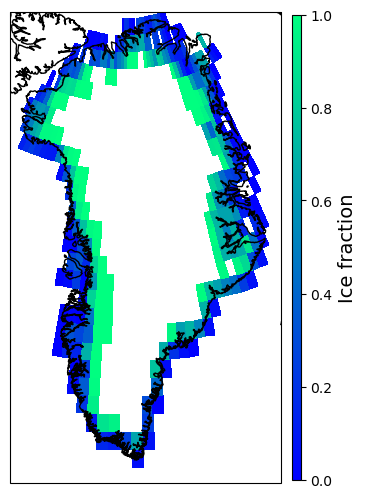

In [9]:
fig = plt.figure(figsize = (3.5,6.2))
gs=GridSpec(1,1)
plt.rcParams['axes.titlepad'] =14

#---------------------------------------------1----------------------------------------------------
ax1 = plt.subplot(gs[0], projection=polar_stereographic)
ax1.set_extent([-56.4, -29.6, 58, 84])
ax1.coastlines(resolution='10m', zorder=7)
#im1 = PolyCollection(ARCTIC_amask_verts, transform=ccrs.PlateCarree(), cmap='winter',
#                     **kwd_polycollection)
#im1.set_array(ARCTIC_amask_var)
#ax1.add_collection(im1)
f09_lon = f09_GrIS_mask_n1.lon
f09_lat = f09_GrIS_mask_n1.lat
im1 = ax1.pcolormesh(f09_lon, f09_lat, f09_GrIS_mask_n1[0,:,:], cmap='winter', transform=ccrs.PlateCarree())
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# colorbar
cbar_ax1 = fig.add_axes([0.93, 0.121, 0.025, 0.75])
cb1 = fig.colorbar(im1, cax=cbar_ax1, orientation='vertical')
cb1.set_label(label='Ice fraction', size=14)
cb1.ax.tick_params(labelsize=10)


plt.subplots_adjust(wspace=0.2)
plt.savefig(home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/Ice_fraction_ablation_LENS2_n1_SSP370_2071_2100.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)


## Data pre-processing

The next question is about stationarity. A trend and seasonal cycle can introduce non-stationary dependencies that cannot be explained causally, that is, can act as confounders. Hence, as pre-processing steps, the trend and seasonal cycle are removed by first substracting both the trend (for example, caused by greenhouse gas forcing) and the seasonal cycle and then dividing by the seasonal variance. The length scale of the Gaussian kernel used for finding the long-term trend is assumed to be decadal ($15$ years). 

Further, considering the regime behavior of the system as explained above, only the summer months June to August are considered. On a technical level, this selection of considered time periods is achieved by applying a so-called mask (also see [masking tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/dataset_challenges/tigramite_tutorial_missing_masking.ipynb) in tigramite).

More specifically, here the mask is such that samples for all the variables at time $t$ can only come from Jun-Aug, while samples for the times $t-1$ and $t-2$ can also come from outside this mask. This masking procedure results in a small sample size of $n=240$. 

The figure below shows (in black) the raw data and overlaid (in red) the sum of 1) the low-frequency variability including the long-term trend, which is obtained by smoothing the time series using a Gaussian kernel with 15-year length scale, and 2) the seasonal cycle of the detrended residuals. Masked samples are in grey.

In [8]:
def process_prepare_pcmci(int_vars, remove_seasonal_cycle=False, add_mask=True, mask_period=[5,6,7]):

    # Stack arrays in sequence vertically (row wise)
    data = np.vstack((
        int_vars['Melt'].values,
        int_vars['SWn'].values,
        int_vars['LWn'].values,
        int_vars['SH'].values,
        int_vars['LH'].values,
                    )).T
    T, N = data.shape

    # Variable names used throughout
    var_names = ['Melt', 'SWn', 'LWn', 'SH', 'LH']

    # Smooth-width set to 15 years
    cycle_length = 12   # a year in monthly time resolution
    smooth_width = 15*cycle_length

    if smooth_width is not None:
        smoothdata_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian', # the low-frequency variability including the long-term trend
                        residuals=False)
        data_here = pp.smooth(np.copy(data), smooth_width=smooth_width, kernel='gaussian', # the detrended residuals or high-frequency variability
                        residuals=True)
    else:
        print("Not smoothed.")
        data_here = np.copy(data)

    # Remove seasonal mean and divide by seasonal standard deviation
    seasonal_cycle = anomalize(np.copy(data_here), cycle_length=cycle_length, return_cycle=True)
    smoothdata_here += seasonal_cycle # the sum of low-frequency variability and seasonal cycle
    if remove_seasonal_cycle == True:
        data_here = anomalize(data_here, cycle_length=cycle_length)

    # Construct mask to only select June to August
    if add_mask == True:
        mask = np.ones(data.shape, dtype='bool')
        for i in mask_period:
            mask[i::cycle_length, :] = False

    # Dataframe for raw data
    #raw_dataframe = pp.DataFrame(np.copy(data), mask=mask, var_names=var_names, datatime={0:np.arange(len(data))})
    # Dataframe for smoothed data
    #smoothdataframe_here = pp.DataFrame(smoothdata_here, var_names=var_names, datatime={0:np.arange(len(data))})
    # Initialize Tigramite dataframe (pre-processed data) with mask, missing_flag is not needed here
    dataframe = pp.DataFrame(data_here, mask=mask, var_names=var_names, missing_flag=999.)

    #data_smooth = data_here # for investigating data dependencies and lag functions

    robustparcorr = RobustParCorr(significance='analytic', mask_type='y')
    pcmci = PCMCI(
        dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0)

    return pcmci

## PCMCI+ causal discovery

Here, since the dependencies in the lag function plot above decay beyond a maximum lag of around 8, we choose ``tau_max=15`` for PCMCI. The other main parameter is ``pc_alpha`` which sets the significance level in the condition-selection step. Here we let PCMCI choose the optimal value by setting it to ``pc_alpha=None``. Then PCMCI will optimize this parameter in the ParCorr case by the Akaike Information criterion among a reasonable default list of values (e.g., ``pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]``). The parameter ``alpha_level=0.01`` indicates that we threshold the resulting p-value matrix at this significance level to obtain the graph.

In the process graph, the node color denotes the auto-MCI value (the link coefficient of the lag-1 autocorrelation links) and the link colors the cross-MCI value (the link coefficients or edge weight). If links occur at multiple lags between two variables, the link color denotes the strongest one and the label lists all significant lags in order of their strength. Additionally, setting ``show_autodependency_lags=True`` will display the significant auto dependencies below the respective node labels. 

You can adjust the size and aspect ratio of nodes with `node_size` and `node_aspect` parameters, and also modify many other properties, see the parameters of `plot_graph` and `plot_time_series_graph`.

In [9]:
file = home_dir+'2023-GrIS-melt-causality/CESM2_F09/historical/LENS2/time_series_LENS2_int_Melt_SEB_ablation_monthly_2071_2100.nc'

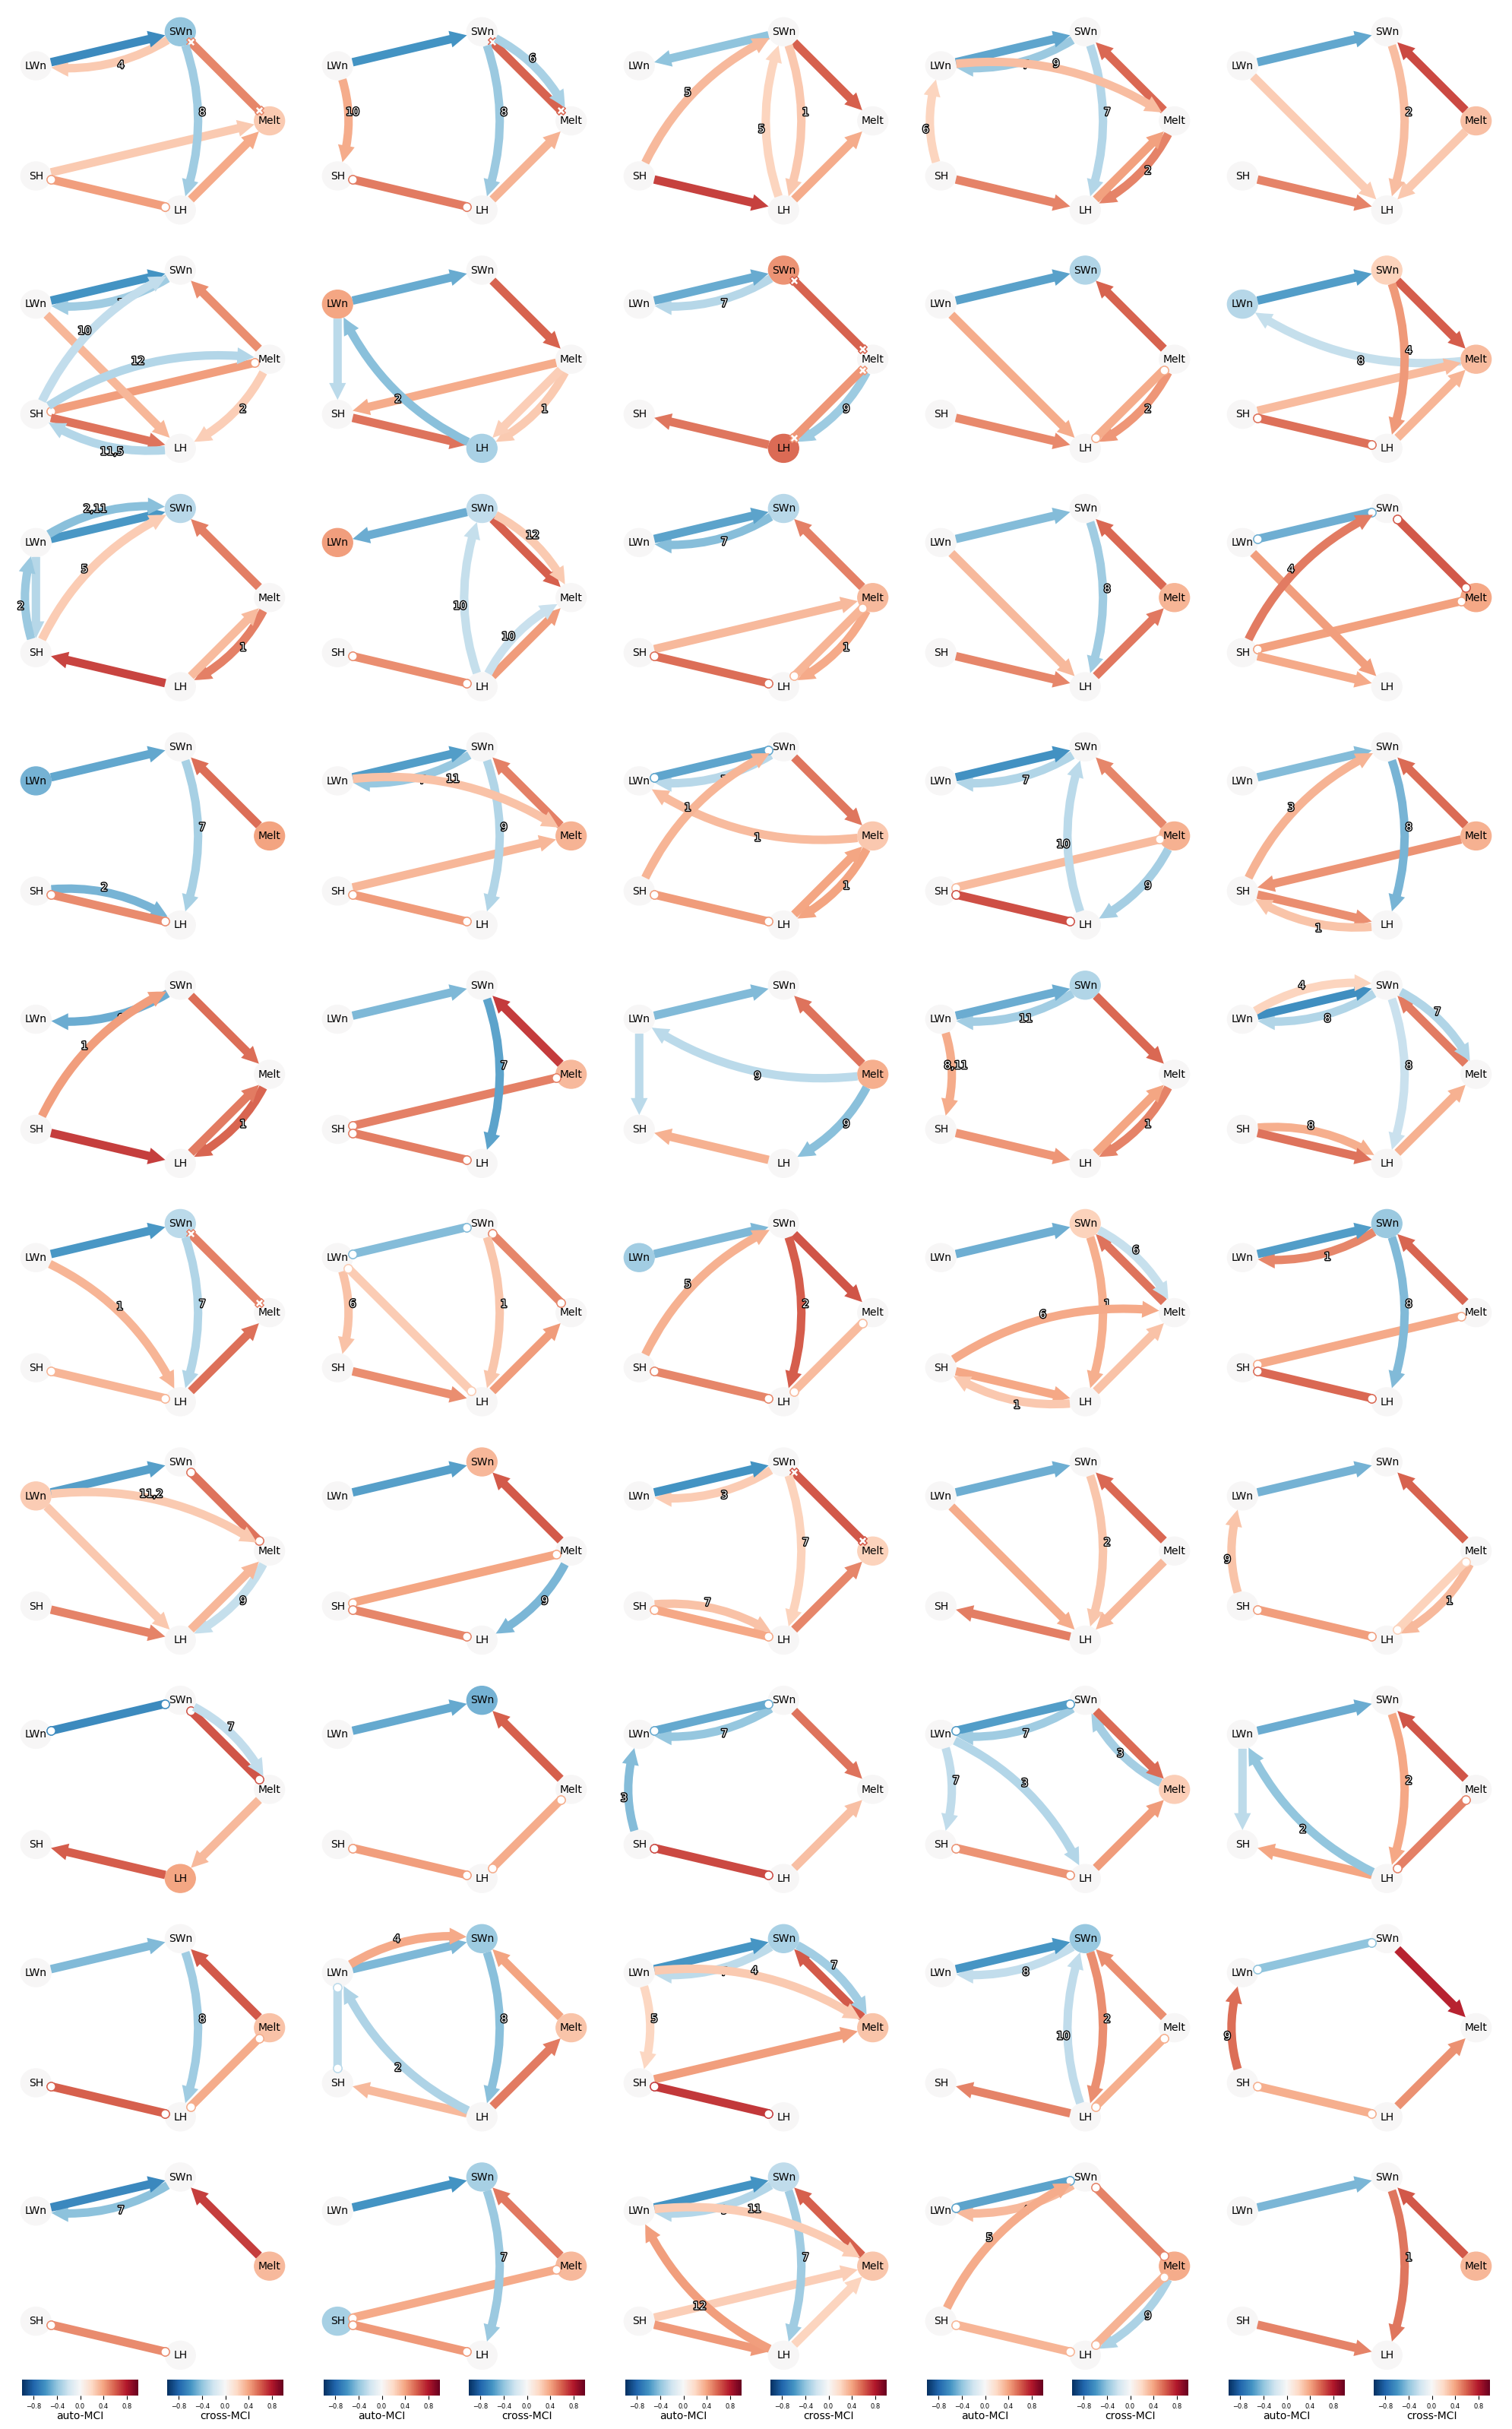

In [6]:
## Define a 10x5 grid layout for 50 subplots
# with seasonality, alpha=None
fig, axs = plt.subplots(10, 5, figsize=(20, 32))
axs = axs.flatten()  # Flatten to easily index subplots

for n in range(1,51):
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))

    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=False, add_mask=True, mask_period=[5,6,7])

    # run without pcmci+ false-discovery rate contral
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=12, pc_alpha=None, contemp_collider_rule='conservative')

    if n <=45:
        tp.plot_graph(
            val_matrix=results['val_matrix'],
            graph=results['graph'],
            var_names=['Melt', 'SWn', 'LWn', 'SH', 'LH'],
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            show_colorbar=False,
            fig_ax=(fig, axs[n-1])
            )
    else:
        tp.plot_graph(
            val_matrix=results['val_matrix'],
            graph=results['graph'],
            var_names=['Melt', 'SWn', 'LWn', 'SH', 'LH'],
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax=(fig, axs[n-1])
            )

plt.tight_layout()
plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graphs_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_seasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax12_alphaNone.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

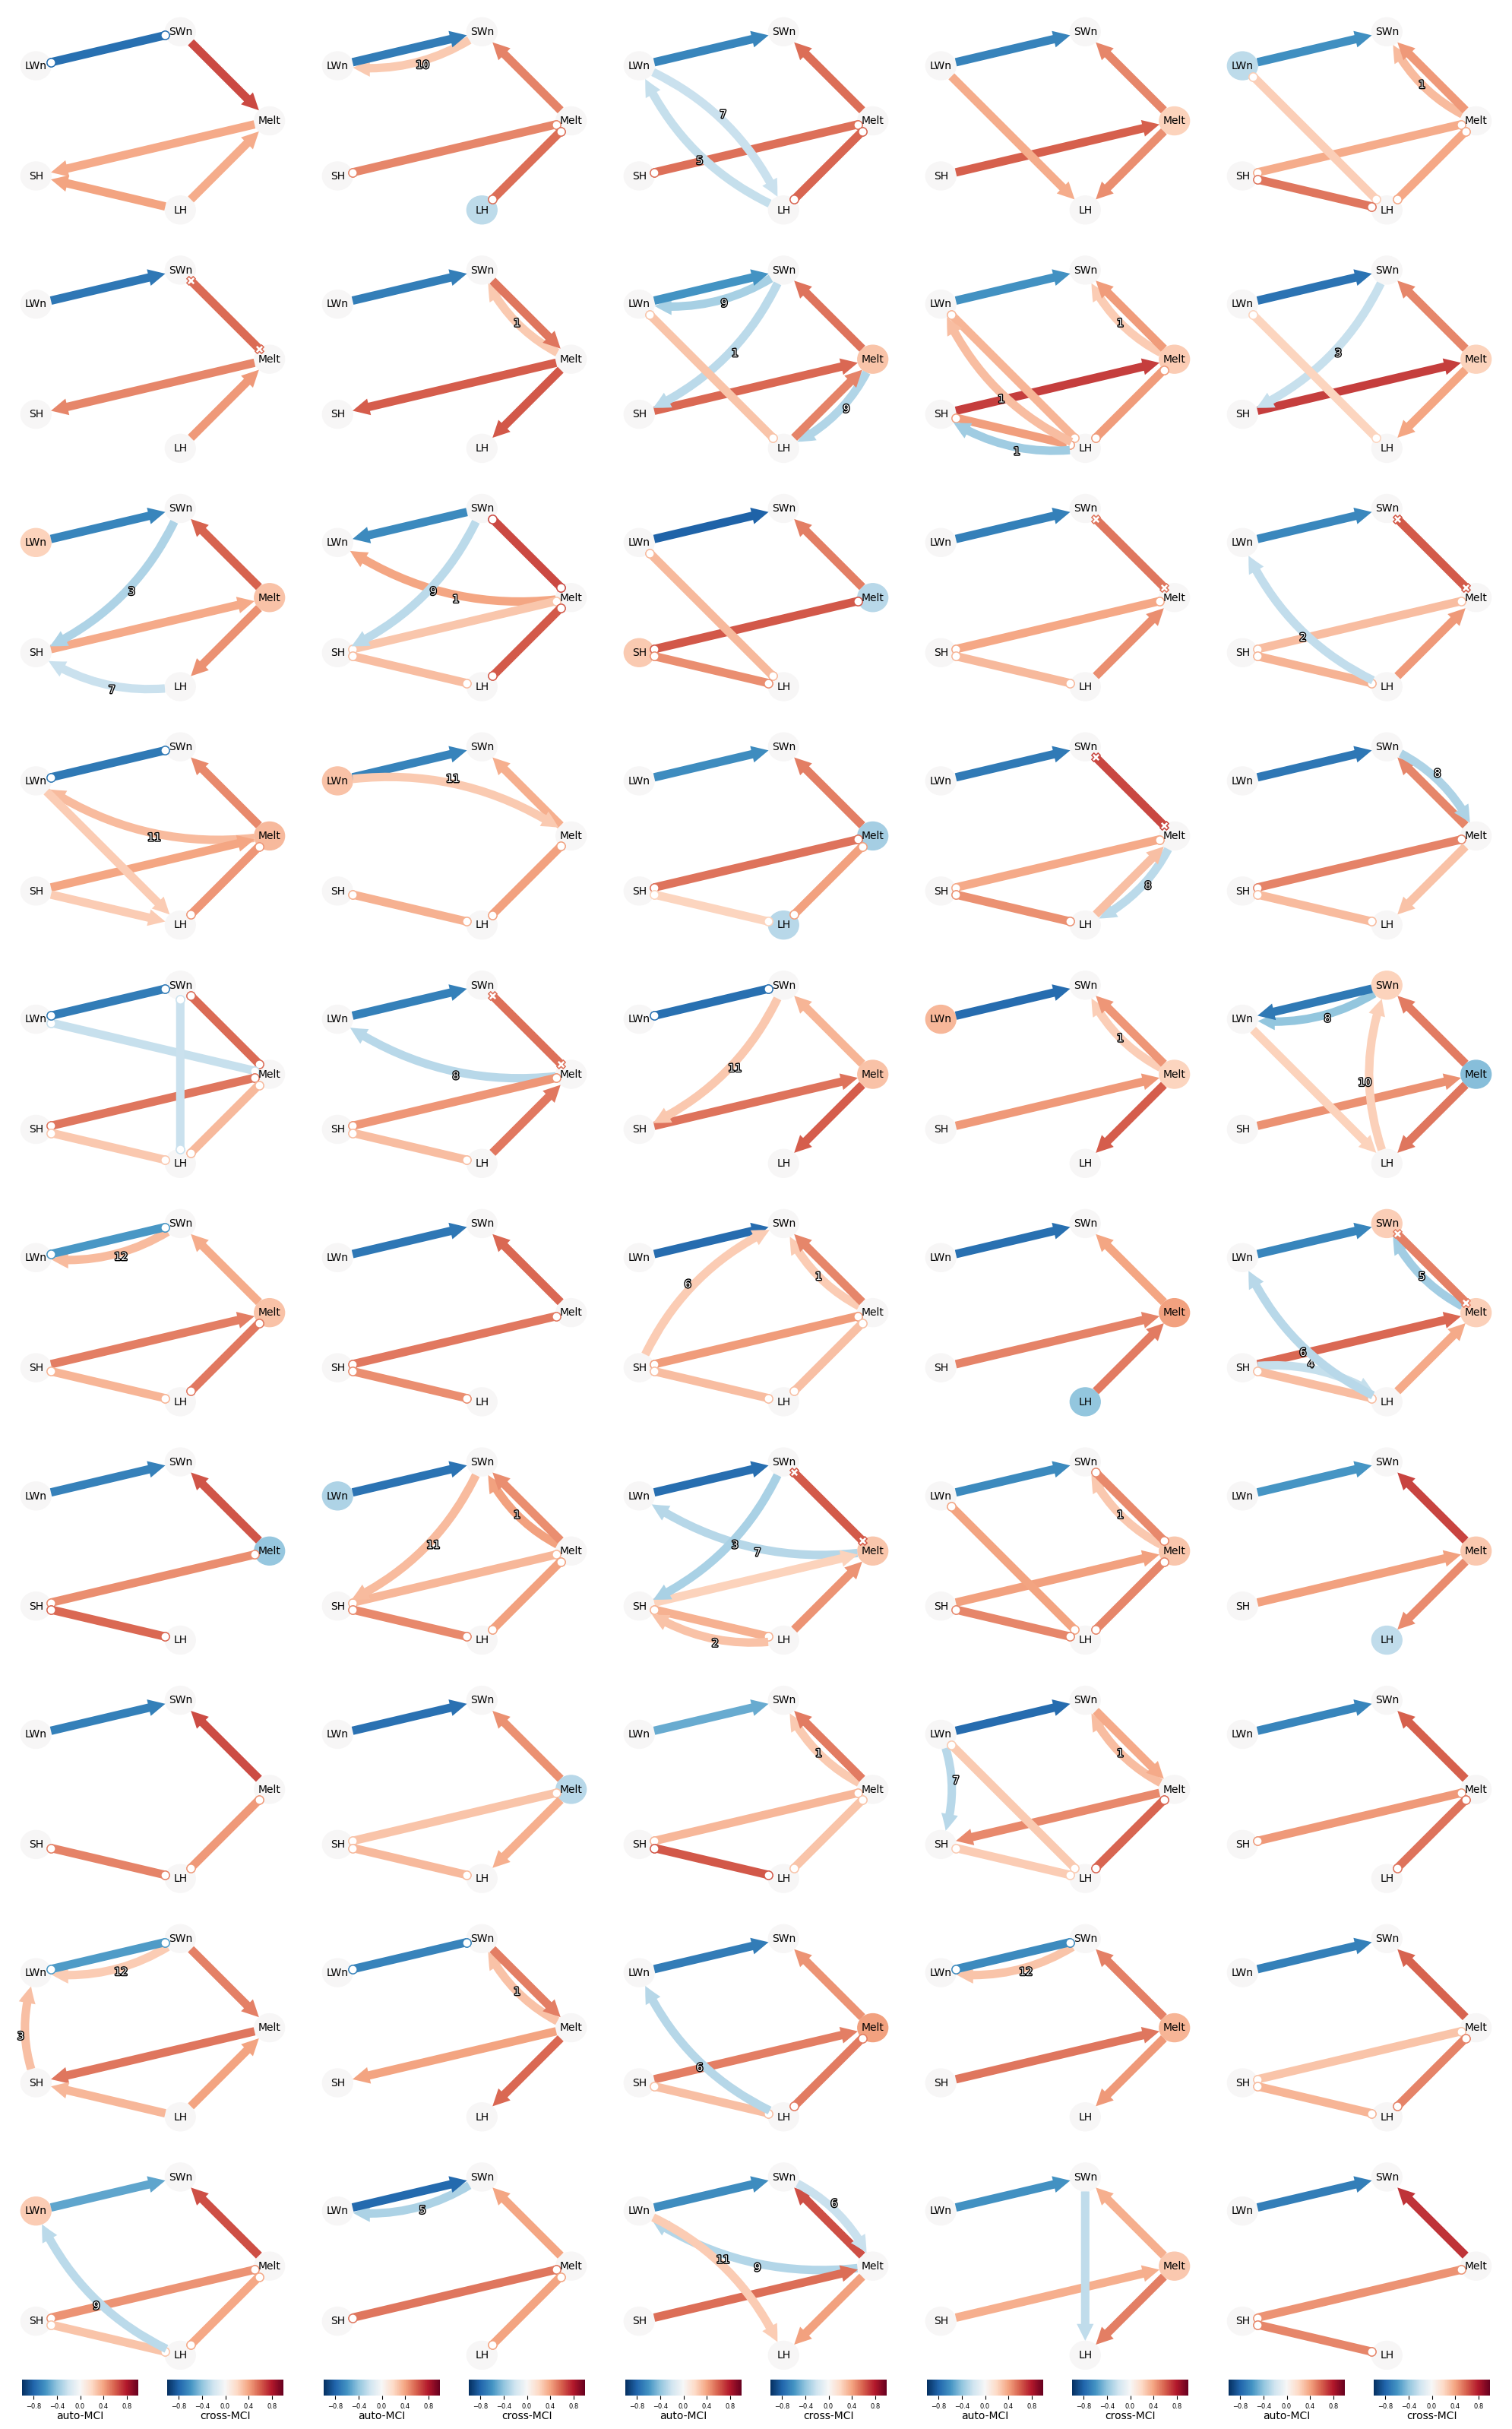

In [15]:
## Define a 10x5 grid layout for 50 subplots
# Without seasonality, alpha=None
fig, axs = plt.subplots(10, 5, figsize=(20, 32))
axs = axs.flatten()  # Flatten to easily index subplots

for n in range(1,51):
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))

    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=True, add_mask=True, mask_period=[5,6,7])

    # run without pcmci+ false-discovery rate contral
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=12, pc_alpha=None, contemp_collider_rule='conservative')

    if n <=45:
        tp.plot_graph(
            val_matrix=results['val_matrix'],
            graph=results['graph'],
            var_names=['Melt', 'SWn', 'LWn', 'SH', 'LH'],
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            show_colorbar=False,
            fig_ax=(fig, axs[n-1])
            )
    else:
        tp.plot_graph(
            val_matrix=results['val_matrix'],
            graph=results['graph'],
            var_names=['Melt', 'SWn', 'LWn', 'SH', 'LH'],
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax=(fig, axs[n-1])
            )

plt.tight_layout()
plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graphs_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax12_alphaNone.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

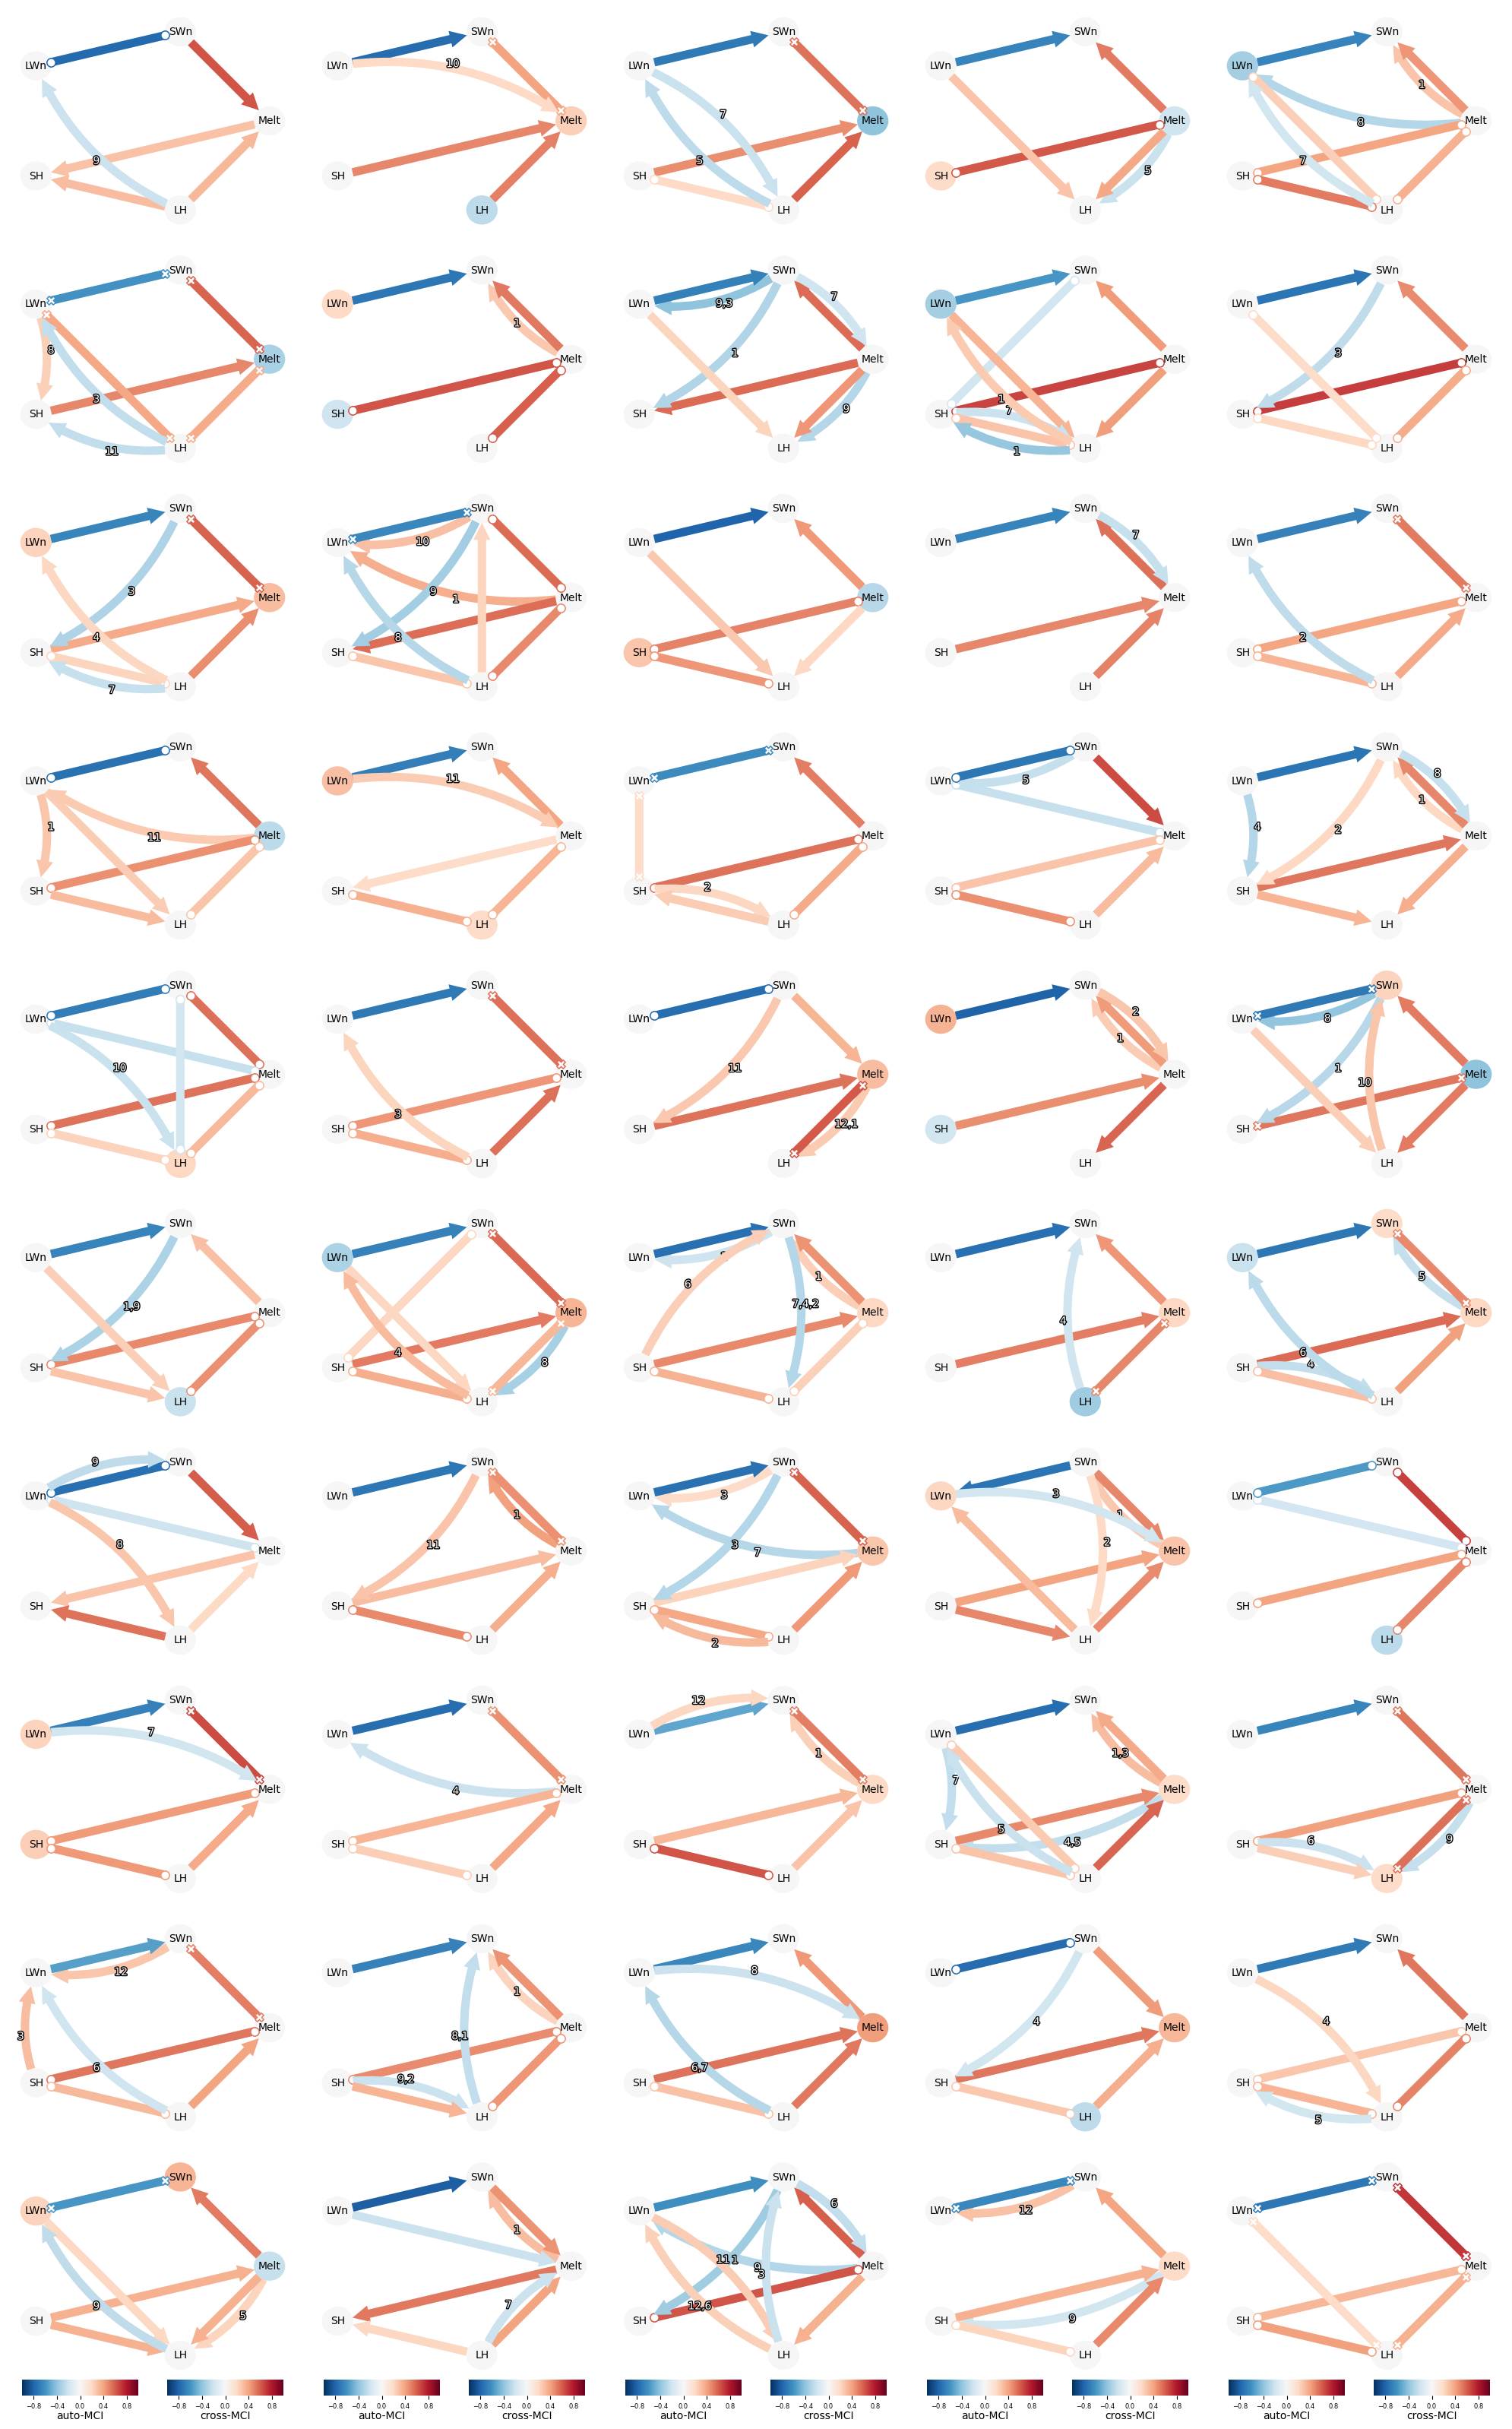

In [16]:
## Define a 10x5 grid layout for 50 subplots
# Without seasonality, alpha=0.1
fig, axs = plt.subplots(10, 5, figsize=(20, 32))
axs = axs.flatten()  # Flatten to easily index subplots

for n in range(1,51):
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))

    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=True, add_mask=True, mask_period=[5,6,7])

    # run without pcmci+ false-discovery rate contral
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=12, pc_alpha=0.1, contemp_collider_rule='conservative')

    if n <=45:
        tp.plot_graph(
            val_matrix=results['val_matrix'],
            graph=results['graph'],
            var_names=['Melt', 'SWn', 'LWn', 'SH', 'LH'],
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            show_colorbar=False,
            fig_ax=(fig, axs[n-1])
            )
    else:
        tp.plot_graph(
            val_matrix=results['val_matrix'],
            graph=results['graph'],
            var_names=['Melt', 'SWn', 'LWn', 'SH', 'LH'],
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            fig_ax=(fig, axs[n-1])
            )

plt.tight_layout()
plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graphs_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax12_alpha01.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

In [48]:
#print("p-values")
#print (results['p_matrix'].round(3))
#print("MCI partial correlations")
#print (results['val_matrix'].round(2))

print("Graph")
print (results['graph'])
print("Adjacency MCI partial correlations")
print (results['val_matrix'].round(2))
print("Adjacency p-values")
print (results['p_matrix'].round(3))

Graph
[[['' '-->' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['-->' '-->' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['-->' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]

 [['<--' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '-->' '' '' '' '' '' '' '' '' '' '' '-->' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '-->' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]

 [['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '-->' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']]

 [['<--' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['x-x' '' '' '' '' '' '' '' '' '' '' '' '' '' '' '']
  ['' '' '

In [31]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=results['val_matrix'],
    graph=results['graph'],
    var_names=['Melt', 'SWn', 'LWn', 'SH', 'LH'],
    save_name='test_graph.csv',
    digits=5,
)

### Aggregated graph

#### Most frequent link

##### with seasonal cycle, max_lag=12, pc_alpha=0.05

In [17]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12  # Maximum lag for PCMCI+
pc_alpha = 0.05
remove_seasonal_cycle = False

# Initialize dictionaries to store aggregated link data by lag
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
node_autocorrelations = defaultdict(list)  # To store autocorrelations for each variable

# Loop through each ensemble member to calculate PCMCI+ results
for n in range(1, 51):  # Assuming 50 ensemble members
    # Load the nth ensemble PCMCI+ results
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    # Extract causality results
    graph = results['graph']
    val_matrix = results['val_matrix']  # Shape should be (num_vars, num_vars, max_lag + 1)

    # Loop over each pair of variables and each lag to store link types and strengths by lag
    for lag in range(0, max_lag + 1):  # Start from lag=0
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:  # Ignore self-links for this part
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    # Append link type and strength to lag-specific dictionary entries
                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Extract lag-1 autocorrelation for each variable from val_matrix diagonal
    for i, var in enumerate(variables):
        lag1_autocorrelation = val_matrix[i, i, 1]  # lag-1 autocorrelation at [i, i, 1]
        node_autocorrelations[var].append(lag1_autocorrelation)

In [18]:
# Dictionary to store the summary causal graph information for each lag
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        # Find the most common link type and its frequency
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        # Skip strength calculation if the most frequent link type is '' (no link)
        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,  # No average strength needed for no-link cases
                'frequency': freq_count
            }
        else:
            # Calculate the average strength for the most frequent link type
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])

            # Store the summarized data
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Calculate average lag-1 autocorrelation for each variable
summary_nodes = {var: np.mean(autocors) for var, autocors in node_autocorrelations.items()}

In [19]:
# Initialize 3D matrices to store the most frequent link type, colors (strength), and widths (frequency) across all lags (including lag=0)
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')  # Shape: (num_vars, num_vars, max_lag + 1)
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

# Populate link type, color, and width matrices for each lag (now including lag=0)
for lag in range(0, max_lag + 1):  # Start from lag=0
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:  # Only include actual links
            link_types[i, j, lag] = link_type  # Store the most frequent link type for this lag
            link_colors[i, j, lag] = avg_strength  # Set color based on average strength
            link_widths[i, j, lag] = frequency  # Set width based on frequency

# Prepare node colors based on average lag-1 autocorrelation
node_colors = [summary_nodes[var] for var in variables]

# Put lag-1 auto-correlation into the link matrice
for i in range(len(variables)):
    link_colors[i,i,1] = node_colors[i]
    link_types[i,i,1] = '-->'

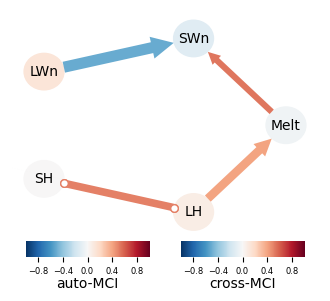

In [20]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_seasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

##### with seasonal cycle, max_lag=12, pc_alpha=0.1

In [21]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12  # Maximum lag for PCMCI+
pc_alpha = 0.1
remove_seasonal_cycle = False

# Initialize dictionaries to store aggregated link data by lag
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
node_autocorrelations = defaultdict(list)  # To store autocorrelations for each variable

# Loop through each ensemble member to calculate PCMCI+ results
for n in range(1, 51):  # Assuming 50 ensemble members
    # Load the nth ensemble PCMCI+ results
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    # Extract causality results
    graph = results['graph']
    val_matrix = results['val_matrix']  # Shape should be (num_vars, num_vars, max_lag + 1)

    # Loop over each pair of variables and each lag to store link types and strengths by lag
    for lag in range(0, max_lag + 1):  # Start from lag=0
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:  # Ignore self-links for this part
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    # Append link type and strength to lag-specific dictionary entries
                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Extract lag-1 autocorrelation for each variable from val_matrix diagonal
    for i, var in enumerate(variables):
        lag1_autocorrelation = val_matrix[i, i, 1]  # lag-1 autocorrelation at [i, i, 1]
        node_autocorrelations[var].append(lag1_autocorrelation)

In [22]:
# Dictionary to store the summary causal graph information for each lag
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        # Find the most common link type and its frequency
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        # Skip strength calculation if the most frequent link type is '' (no link)
        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,  # No average strength needed for no-link cases
                'frequency': freq_count
            }
        else:
            # Calculate the average strength for the most frequent link type
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])

            # Store the summarized data
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Calculate average lag-1 autocorrelation for each variable
summary_nodes = {var: np.mean(autocors) for var, autocors in node_autocorrelations.items()}

In [23]:
# Initialize 3D matrices to store the most frequent link type, colors (strength), and widths (frequency) across all lags (including lag=0)
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')  # Shape: (num_vars, num_vars, max_lag + 1)
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

# Populate link type, color, and width matrices for each lag (now including lag=0)
for lag in range(0, max_lag + 1):  # Start from lag=0
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:  # Only include actual links
            link_types[i, j, lag] = link_type  # Store the most frequent link type for this lag
            link_colors[i, j, lag] = avg_strength  # Set color based on average strength
            link_widths[i, j, lag] = frequency  # Set width based on frequency

# Prepare node colors based on average lag-1 autocorrelation
node_colors = [summary_nodes[var] for var in variables]

# Put lag-1 auto-correlation into the link matrice
for i in range(len(variables)):
    link_colors[i,i,1] = node_colors[i]
    link_types[i,i,1] = '-->'

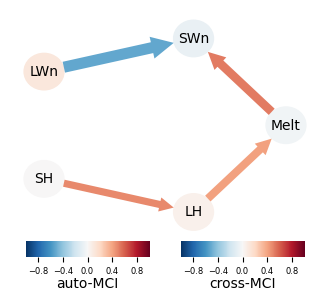

In [24]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_seasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

##### with seasonal cycle, max_lag=12, pc_alpha=None

In [25]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12  # Maximum lag for PCMCI+
pc_alpha = None
remove_seasonal_cycle = False

# Initialize dictionaries to store aggregated link data by lag
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
node_autocorrelations = defaultdict(list)  # To store autocorrelations for each variable

# Loop through each ensemble member to calculate PCMCI+ results
for n in range(1, 51):  # Assuming 50 ensemble members
    # Load the nth ensemble PCMCI+ results
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    # Extract causality results
    graph = results['graph']
    val_matrix = results['val_matrix']  # Shape should be (num_vars, num_vars, max_lag + 1)

    # Loop over each pair of variables and each lag to store link types and strengths by lag
    for lag in range(0, max_lag + 1):  # Start from lag=0
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:  # Ignore self-links for this part
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    # Append link type and strength to lag-specific dictionary entries
                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Extract lag-1 autocorrelation for each variable from val_matrix diagonal
    for i, var in enumerate(variables):
        lag1_autocorrelation = val_matrix[i, i, 1]  # lag-1 autocorrelation at [i, i, 1]
        node_autocorrelations[var].append(lag1_autocorrelation)

In [26]:
# Dictionary to store the summary causal graph information for each lag
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        # Find the most common link type and its frequency
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        # Skip strength calculation if the most frequent link type is '' (no link)
        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,  # No average strength needed for no-link cases
                'frequency': freq_count
            }
        else:
            # Calculate the average strength for the most frequent link type
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])

            # Store the summarized data
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Calculate average lag-1 autocorrelation for each variable
summary_nodes = {var: np.mean(autocors) for var, autocors in node_autocorrelations.items()}

In [27]:
# Initialize 3D matrices to store the most frequent link type, colors (strength), and widths (frequency) across all lags (including lag=0)
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')  # Shape: (num_vars, num_vars, max_lag + 1)
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

# Populate link type, color, and width matrices for each lag (now including lag=0)
for lag in range(0, max_lag + 1):  # Start from lag=0
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:  # Only include actual links
            link_types[i, j, lag] = link_type  # Store the most frequent link type for this lag
            link_colors[i, j, lag] = avg_strength  # Set color based on average strength
            link_widths[i, j, lag] = frequency  # Set width based on frequency

# Prepare node colors based on average lag-1 autocorrelation
node_colors = [summary_nodes[var] for var in variables]

# Put lag-1 auto-correlation into the link matrice
for i in range(len(variables)):
    link_colors[i,i,1] = node_colors[i]
    link_types[i,i,1] = '-->'

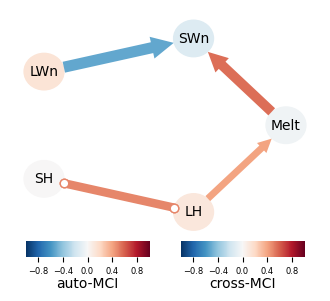

In [28]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_seasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

##### without seasonal cycle, max_lag=12, pc_alpha=0.05

In [29]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12  # Maximum lag for PCMCI+
pc_alpha = 0.05
remove_seasonal_cycle = True

# Initialize dictionaries to store aggregated link data by lag
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
node_autocorrelations = defaultdict(list)  # To store autocorrelations for each variable

# Loop through each ensemble member to calculate PCMCI+ results
for n in range(1, 51):  # Assuming 50 ensemble members
    # Load the nth ensemble PCMCI+ results
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    # Extract causality results
    graph = results['graph']
    val_matrix = results['val_matrix']  # Shape should be (num_vars, num_vars, max_lag + 1)

    # Loop over each pair of variables and each lag to store link types and strengths by lag
    for lag in range(0, max_lag + 1):  # Start from lag=0
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:  # Ignore self-links for this part
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    # Append link type and strength to lag-specific dictionary entries
                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Extract lag-1 autocorrelation for each variable from val_matrix diagonal
    for i, var in enumerate(variables):
        lag1_autocorrelation = val_matrix[i, i, 1]  # lag-1 autocorrelation at [i, i, 1]
        node_autocorrelations[var].append(lag1_autocorrelation)

In [30]:
# Dictionary to store the summary causal graph information for each lag
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        # Find the most common link type and its frequency
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        # Skip strength calculation if the most frequent link type is '' (no link)
        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,  # No average strength needed for no-link cases
                'frequency': freq_count
            }
        else:
            # Calculate the average strength for the most frequent link type
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])

            # Store the summarized data
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Calculate average lag-1 autocorrelation for each variable
summary_nodes = {var: np.mean(autocors) for var, autocors in node_autocorrelations.items()}

In [31]:
# Initialize 3D matrices to store the most frequent link type, colors (strength), and widths (frequency) across all lags (including lag=0)
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')  # Shape: (num_vars, num_vars, max_lag + 1)
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

# Populate link type, color, and width matrices for each lag (now including lag=0)
for lag in range(0, max_lag + 1):  # Start from lag=0
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:  # Only include actual links
            link_types[i, j, lag] = link_type  # Store the most frequent link type for this lag
            link_colors[i, j, lag] = avg_strength  # Set color based on average strength
            link_widths[i, j, lag] = frequency  # Set width based on frequency

# Prepare node colors based on average lag-1 autocorrelation
node_colors = [summary_nodes[var] for var in variables]

# Put lag-1 auto-correlation into the link matrice
for i in range(len(variables)):
    link_colors[i,i,1] = node_colors[i]
    link_types[i,i,1] = '-->'

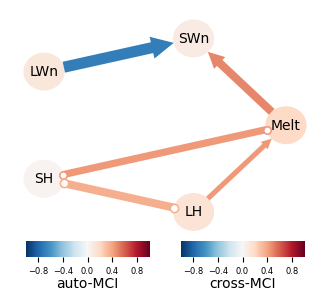

In [32]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [33]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=link_colors,
    graph=link_types,
    var_names=variables,
    link_width=link_widths,
    save_name=plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.csv',
    digits=5,
)

##### without seasonal cycle, max_lag=12, pc_alpha=0.1

In [9]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12  # Maximum lag for PCMCI+
pc_alpha = 0.1
remove_seasonal_cycle = True

# Initialize dictionaries to store aggregated link data by lag
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
node_autocorrelations = defaultdict(list)  # To store autocorrelations for each variable

# Loop through each ensemble member to calculate PCMCI+ results
for n in range(1, 51):  # Assuming 50 ensemble members
    # Load the nth ensemble PCMCI+ results
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    # Extract causality results
    graph = results['graph']
    val_matrix = results['val_matrix']  # Shape should be (num_vars, num_vars, max_lag + 1)

    # Loop over each pair of variables and each lag to store link types and strengths by lag
    for lag in range(0, max_lag + 1):  # Start from lag=0
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:  # Ignore self-links for this part
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    # Append link type and strength to lag-specific dictionary entries
                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Extract lag-1 autocorrelation for each variable from val_matrix diagonal
    for i, var in enumerate(variables):
        lag1_autocorrelation = val_matrix[i, i, 1]  # lag-1 autocorrelation at [i, i, 1]
        node_autocorrelations[var].append(lag1_autocorrelation)

In [10]:
# Dictionary to store the summary causal graph information for each lag
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        # Find the most common link type and its frequency
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        # Skip strength calculation if the most frequent link type is '' (no link)
        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,  # No average strength needed for no-link cases
                'frequency': freq_count
            }
        else:
            # Calculate the average strength for the most frequent link type
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])

            # Store the summarized data
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Calculate average lag-1 autocorrelation for each variable
summary_nodes = {var: np.mean(autocors) for var, autocors in node_autocorrelations.items()}

In [36]:
# Initialize 3D matrices to store the most frequent link type, colors (strength), and widths (frequency) across all lags (including lag=0)
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')  # Shape: (num_vars, num_vars, max_lag + 1)
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

# Populate link type, color, and width matrices for each lag (now including lag=0)
for lag in range(0, max_lag + 1):  # Start from lag=0
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:  # Only include actual links
            link_types[i, j, lag] = link_type  # Store the most frequent link type for this lag
            link_colors[i, j, lag] = avg_strength  # Set color based on average strength
            link_widths[i, j, lag] = frequency  # Set width based on frequency

# Prepare node colors based on average lag-1 autocorrelation
node_colors = [summary_nodes[var] for var in variables]

# Put lag-1 auto-correlation into the link matrice
for i in range(len(variables)):
    link_colors[i,i,1] = node_colors[i]
    link_types[i,i,1] = '-->'

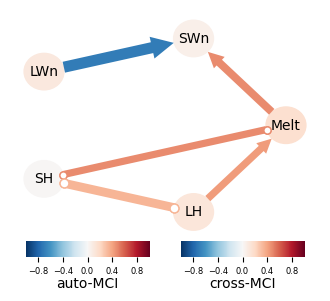

In [37]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [38]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=link_colors,
    graph=link_types,
    var_names=variables,
    link_width=link_widths,
    save_name=plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.csv',
    digits=5,
)

In [11]:
plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/2071_2100/'
save_name = plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.csv'
pd.read_csv(save_name)

Variable i Variable j  Time lag of i Link type i --- j  Link value  \
0       Melt       Melt              1               -->    0.162400   
1       Melt        SWn              0               -->    0.470830   
2       Melt         SH              0               o-o    0.475270   
3       Melt         LH              0               <--    0.423940   
4        SWn        SWn              1               -->    0.060775   
5        SWn        LWn              0               <--   -0.698770   
6        LWn        LWn              1               -->    0.108830   
7         SH         SH              1               -->    0.012473   
8         SH         LH              0               o-o    0.342120   
9         LH         LH              1               -->    0.121160   

   Link width  
0         0.0  
1        24.0  
2        22.0  
3        22.0  
4         0.0  
5        34.0  
6         0.0  
7         0.0  
8        27.0  
9         0.0

##### without seasonal cycle, max_lag=12, pc_alpha=None

In [39]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12  # Maximum lag for PCMCI+
pc_alpha = None
remove_seasonal_cycle = True

# Initialize dictionaries to store aggregated link data by lag
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
node_autocorrelations = defaultdict(list)  # To store autocorrelations for each variable

# Loop through each ensemble member to calculate PCMCI+ results
for n in range(1, 51):  # Assuming 50 ensemble members
    # Load the nth ensemble PCMCI+ results
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    # Extract causality results
    graph = results['graph']
    val_matrix = results['val_matrix']  # Shape should be (num_vars, num_vars, max_lag + 1)

    # Loop over each pair of variables and each lag to store link types and strengths by lag
    for lag in range(0, max_lag + 1):  # Start from lag=0
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:  # Ignore self-links for this part
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    # Append link type and strength to lag-specific dictionary entries
                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Extract lag-1 autocorrelation for each variable from val_matrix diagonal
    for i, var in enumerate(variables):
        lag1_autocorrelation = val_matrix[i, i, 1]  # lag-1 autocorrelation at [i, i, 1]
        node_autocorrelations[var].append(lag1_autocorrelation)

In [40]:
# Dictionary to store the summary causal graph information for each lag
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        # Find the most common link type and its frequency
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        # Skip strength calculation if the most frequent link type is '' (no link)
        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,  # No average strength needed for no-link cases
                'frequency': freq_count
            }
        else:
            # Calculate the average strength for the most frequent link type
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])

            # Store the summarized data
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Calculate average lag-1 autocorrelation for each variable
summary_nodes = {var: np.mean(autocors) for var, autocors in node_autocorrelations.items()}

In [41]:
# Initialize 3D matrices to store the most frequent link type, colors (strength), and widths (frequency) across all lags (including lag=0)
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')  # Shape: (num_vars, num_vars, max_lag + 1)
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

# Populate link type, color, and width matrices for each lag (now including lag=0)
for lag in range(0, max_lag + 1):  # Start from lag=0
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:  # Only include actual links
            link_types[i, j, lag] = link_type  # Store the most frequent link type for this lag
            link_colors[i, j, lag] = avg_strength  # Set color based on average strength
            link_widths[i, j, lag] = frequency  # Set width based on frequency

# Prepare node colors based on average lag-1 autocorrelation
node_colors = [summary_nodes[var] for var in variables]

# Put lag-1 auto-correlation into the link matrice
for i in range(len(variables)):
    link_colors[i,i,1] = node_colors[i]
    link_types[i,i,1] = '-->'

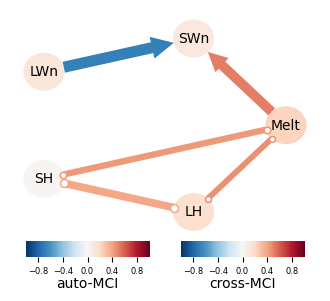

In [42]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [43]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=link_colors,
    graph=link_types,
    var_names=variables,
    link_width=link_widths,
    save_name=plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.csv',
    digits=5,
)

##### without seasonal cycle, max_lag=3, pc_alpha=0.1

In [44]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 3  # Maximum lag for PCMCI+
pc_alpha = 0.1
remove_seasonal_cycle = True

# Initialize dictionaries to store aggregated link data by lag
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
node_autocorrelations = defaultdict(list)  # To store autocorrelations for each variable

# Loop through each ensemble member to calculate PCMCI+ results
for n in range(1, 51):  # Assuming 50 ensemble members
    # Load the nth ensemble PCMCI+ results
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    # Extract causality results
    graph = results['graph']
    val_matrix = results['val_matrix']  # Shape should be (num_vars, num_vars, max_lag + 1)

    # Loop over each pair of variables and each lag to store link types and strengths by lag
    for lag in range(0, max_lag + 1):  # Start from lag=0
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:  # Ignore self-links for this part
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    # Append link type and strength to lag-specific dictionary entries
                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Extract lag-1 autocorrelation for each variable from val_matrix diagonal
    for i, var in enumerate(variables):
        lag1_autocorrelation = val_matrix[i, i, 1]  # lag-1 autocorrelation at [i, i, 1]
        node_autocorrelations[var].append(lag1_autocorrelation)

In [45]:
# Dictionary to store the summary causal graph information for each lag
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        # Find the most common link type and its frequency
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        # Skip strength calculation if the most frequent link type is '' (no link)
        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,  # No average strength needed for no-link cases
                'frequency': freq_count
            }
        else:
            # Calculate the average strength for the most frequent link type
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])

            # Store the summarized data
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Calculate average lag-1 autocorrelation for each variable
summary_nodes = {var: np.mean(autocors) for var, autocors in node_autocorrelations.items()}

In [46]:
# Initialize 3D matrices to store the most frequent link type, colors (strength), and widths (frequency) across all lags (including lag=0)
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')  # Shape: (num_vars, num_vars, max_lag + 1)
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

# Populate link type, color, and width matrices for each lag (now including lag=0)
for lag in range(0, max_lag + 1):  # Start from lag=0
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:  # Only include actual links
            link_types[i, j, lag] = link_type  # Store the most frequent link type for this lag
            link_colors[i, j, lag] = avg_strength  # Set color based on average strength
            link_widths[i, j, lag] = frequency  # Set width based on frequency

# Prepare node colors based on average lag-1 autocorrelation
node_colors = [summary_nodes[var] for var in variables]

# Put lag-1 auto-correlation into the link matrice
for i in range(len(variables)):
    link_colors[i,i,1] = node_colors[i]
    link_types[i,i,1] = '-->'

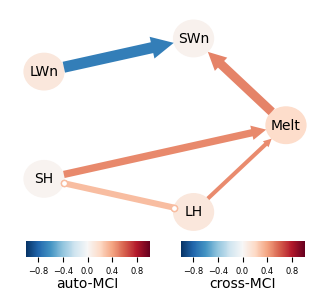

In [47]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

##### without seasonal cycle, max_lag=6, pc_alpha=None

In [48]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 6  # Maximum lag for PCMCI+
pc_alpha = None
remove_seasonal_cycle = True

# Initialize dictionaries to store aggregated link data by lag
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
node_autocorrelations = defaultdict(list)  # To store autocorrelations for each variable

# Loop through each ensemble member to calculate PCMCI+ results
for n in range(1, 51):  # Assuming 50 ensemble members
    # Load the nth ensemble PCMCI+ results
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    # Extract causality results
    graph = results['graph']
    val_matrix = results['val_matrix']  # Shape should be (num_vars, num_vars, max_lag + 1)

    # Loop over each pair of variables and each lag to store link types and strengths by lag
    for lag in range(0, max_lag + 1):  # Start from lag=0
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:  # Ignore self-links for this part
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    # Append link type and strength to lag-specific dictionary entries
                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Extract lag-1 autocorrelation for each variable from val_matrix diagonal
    for i, var in enumerate(variables):
        lag1_autocorrelation = val_matrix[i, i, 1]  # lag-1 autocorrelation at [i, i, 1]
        node_autocorrelations[var].append(lag1_autocorrelation)

In [49]:
# Dictionary to store the summary causal graph information for each lag
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        # Find the most common link type and its frequency
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        # Skip strength calculation if the most frequent link type is '' (no link)
        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,  # No average strength needed for no-link cases
                'frequency': freq_count
            }
        else:
            # Calculate the average strength for the most frequent link type
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])

            # Store the summarized data
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Calculate average lag-1 autocorrelation for each variable
summary_nodes = {var: np.mean(autocors) for var, autocors in node_autocorrelations.items()}

In [50]:
# Initialize 3D matrices to store the most frequent link type, colors (strength), and widths (frequency) across all lags (including lag=0)
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')  # Shape: (num_vars, num_vars, max_lag + 1)
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

# Populate link type, color, and width matrices for each lag (now including lag=0)
for lag in range(0, max_lag + 1):  # Start from lag=0
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:  # Only include actual links
            link_types[i, j, lag] = link_type  # Store the most frequent link type for this lag
            link_colors[i, j, lag] = avg_strength  # Set color based on average strength
            link_widths[i, j, lag] = frequency  # Set width based on frequency

# Prepare node colors based on average lag-1 autocorrelation
node_colors = [summary_nodes[var] for var in variables]

# Put lag-1 auto-correlation into the link matrice
for i in range(len(variables)):
    link_colors[i,i,1] = node_colors[i]
    link_types[i,i,1] = '-->'

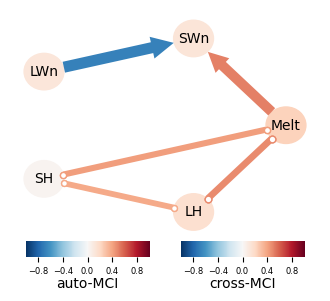

In [51]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

##### without seasonal cycle, max_lag=15, pc_alpha=None

In [52]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 15  # Maximum lag for PCMCI+
pc_alpha = None
remove_seasonal_cycle = True

# Initialize dictionaries to store aggregated link data by lag
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
node_autocorrelations = defaultdict(list)  # To store autocorrelations for each variable

# Loop through each ensemble member to calculate PCMCI+ results
for n in range(1, 51):  # Assuming 50 ensemble members
    # Load the nth ensemble PCMCI+ results
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    # Extract causality results
    graph = results['graph']
    val_matrix = results['val_matrix']  # Shape should be (num_vars, num_vars, max_lag + 1)

    # Loop over each pair of variables and each lag to store link types and strengths by lag
    for lag in range(0, max_lag + 1):  # Start from lag=0
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:  # Ignore self-links for this part
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    # Append link type and strength to lag-specific dictionary entries
                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Extract lag-1 autocorrelation for each variable from val_matrix diagonal
    for i, var in enumerate(variables):
        lag1_autocorrelation = val_matrix[i, i, 1]  # lag-1 autocorrelation at [i, i, 1]
        node_autocorrelations[var].append(lag1_autocorrelation)

In [53]:
# Dictionary to store the summary causal graph information for each lag
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        # Find the most common link type and its frequency
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        # Skip strength calculation if the most frequent link type is '' (no link)
        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,  # No average strength needed for no-link cases
                'frequency': freq_count
            }
        else:
            # Calculate the average strength for the most frequent link type
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])

            # Store the summarized data
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Calculate average lag-1 autocorrelation for each variable
summary_nodes = {var: np.mean(autocors) for var, autocors in node_autocorrelations.items()}

In [54]:
# Initialize 3D matrices to store the most frequent link type, colors (strength), and widths (frequency) across all lags (including lag=0)
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')  # Shape: (num_vars, num_vars, max_lag + 1)
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

# Populate link type, color, and width matrices for each lag (now including lag=0)
for lag in range(0, max_lag + 1):  # Start from lag=0
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:  # Only include actual links
            link_types[i, j, lag] = link_type  # Store the most frequent link type for this lag
            link_colors[i, j, lag] = avg_strength  # Set color based on average strength
            link_widths[i, j, lag] = frequency  # Set width based on frequency

# Prepare node colors based on average lag-1 autocorrelation
node_colors = [summary_nodes[var] for var in variables]

# Put lag-1 auto-correlation into the link matrice
for i in range(len(variables)):
    link_colors[i,i,1] = node_colors[i]
    link_types[i,i,1] = '-->'

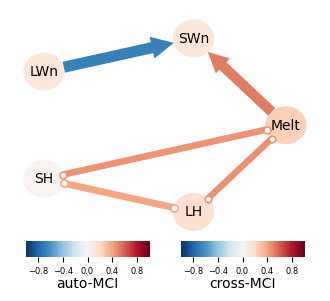

In [55]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

### Aggregated graph (corrected for significance of self-MCI)

##### without seasonal cycle, max_lag=12, pc_alpha=0.025

In [36]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12
pc_alpha = 0.025
remove_seasonal_cycle = True

# Initialize storage
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}

# For auto-MCI: store max self-MCI value and significance across ensemble members
node_self_mci_values = defaultdict(list)       # Max auto-MCI values
node_self_mci_significance = defaultdict(list) # Whether max auto-MCI is significant

for n in range(1, 51):  # Loop over 50 ensemble members
    # Load and prepare data
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    graph = results['graph']
    val_matrix = results['val_matrix']

    # Collect cross-links
    for lag in range(0, max_lag + 1):
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Compute max auto-MCI (across all lags ≥1) and check significance
    for i, var in enumerate(variables):
        # Extract all self-lag values
        self_vals = val_matrix[i, i, 1:]
        max_val = np.max(np.abs(self_vals))   # Max magnitude auto-MCI
        max_lag_idx = np.argmax(np.abs(self_vals)) + 1  # Which lag

        # Check significance: is there a self-link at that lag in the graph?
        is_significant = graph[i, i, max_lag_idx] != '' and graph[i, i, max_lag_idx] != 'o-o'

        node_self_mci_values[var].append(max_val)
        node_self_mci_significance[var].append(is_significant)

In [37]:
# Summarize cross-links as before
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,
                'frequency': freq_count
            }
        else:
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Compute node colors: average max auto-MCI, but set to 0 if not significant in majority of members
summary_nodes = {}
for var in variables:
    # Fraction of members where max auto-MCI is significant
    sig_fraction = np.mean(node_self_mci_significance[var])

    if sig_fraction > 0.5:  # majority significant
        summary_nodes[var] = np.mean(node_self_mci_values[var])
    else:
        summary_nodes[var] = 0.0

In [38]:
# Prepare matrices for cross-links
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

for lag in range(0, max_lag + 1):
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:
            link_types[i, j, lag] = link_type
            link_colors[i, j, lag] = avg_strength
            link_widths[i, j, lag] = frequency

# Node colors: summary_nodes already considers significance
node_colors = [summary_nodes[var] for var in variables]

# Assign node colors to self-link at lag 1 (for plotting)
for i in range(num_vars):
    link_colors[i, i, 1] = node_colors[i]
    link_types[i, i, 1] = '-->'

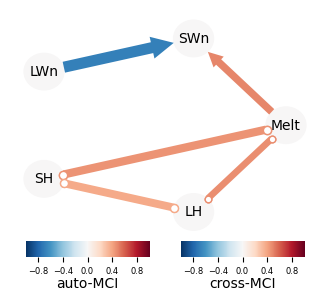

In [39]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [40]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=link_colors,
    graph=link_types,
    var_names=variables,
    link_width=link_widths,
    save_name=home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv',
    digits=5,
)

In [41]:
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv'
pd.read_csv(save_name)

Variable i Variable j  Time lag of i Link type i --- j  Link value  \
0       Melt       Melt              1               -->     0.00000   
1       Melt        SWn              0               -->     0.48642   
2       Melt         SH              0               o-o     0.44588   
3       Melt         LH              0               o-o     0.46659   
4        SWn        SWn              1               -->     0.00000   
5        SWn        LWn              0               <--    -0.68227   
6        LWn        LWn              1               -->     0.00000   
7         SH         SH              1               -->     0.00000   
8         SH         LH              0               o-o     0.37631   
9         LH         LH              1               -->     0.00000   

   Link width  
0         0.0  
1        28.0  
2        31.0  
3        25.0  
4         0.0  
5        42.0  
6         0.0  
7         0.0  
8        30.0  
9         0.0

In [42]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'

np.savez(save_name,
         val_matrix=link_colors,
         graph=link_types,
         link_width=link_widths,
         var_names=np.array(variables))

##### without seasonal cycle, max_lag=12, pc_alpha=0.05

In [29]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12
pc_alpha = 0.05
remove_seasonal_cycle = True

# Initialize storage
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}

# For auto-MCI: store max self-MCI value and significance across ensemble members
node_self_mci_values = defaultdict(list)       # Max auto-MCI values
node_self_mci_significance = defaultdict(list) # Whether max auto-MCI is significant

for n in range(1, 51):  # Loop over 50 ensemble members
    # Load and prepare data
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    graph = results['graph']
    val_matrix = results['val_matrix']

    # Collect cross-links
    for lag in range(0, max_lag + 1):
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Compute max auto-MCI (across all lags ≥1) and check significance
    for i, var in enumerate(variables):
        # Extract all self-lag values
        self_vals = val_matrix[i, i, 1:]
        max_val = np.max(np.abs(self_vals))   # Max magnitude auto-MCI
        max_lag_idx = np.argmax(np.abs(self_vals)) + 1  # Which lag

        # Check significance: is there a self-link at that lag in the graph?
        is_significant = graph[i, i, max_lag_idx] != '' and graph[i, i, max_lag_idx] != 'o-o'

        node_self_mci_values[var].append(max_val)
        node_self_mci_significance[var].append(is_significant)

In [30]:
# Summarize cross-links as before
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,
                'frequency': freq_count
            }
        else:
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Compute node colors: average max auto-MCI, but set to 0 if not significant in majority of members
summary_nodes = {}
for var in variables:
    # Fraction of members where max auto-MCI is significant
    sig_fraction = np.mean(node_self_mci_significance[var])

    if sig_fraction > 0.5:  # majority significant
        summary_nodes[var] = np.mean(node_self_mci_values[var])
    else:
        summary_nodes[var] = 0.0

In [31]:
# Prepare matrices for cross-links
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

for lag in range(0, max_lag + 1):
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:
            link_types[i, j, lag] = link_type
            link_colors[i, j, lag] = avg_strength
            link_widths[i, j, lag] = frequency

# Node colors: summary_nodes already considers significance
node_colors = [summary_nodes[var] for var in variables]

# Assign node colors to self-link at lag 1 (for plotting)
for i in range(num_vars):
    link_colors[i, i, 1] = node_colors[i]
    link_types[i, i, 1] = '-->'

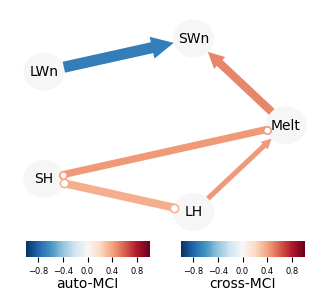

In [32]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [33]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=link_colors,
    graph=link_types,
    var_names=variables,
    link_width=link_widths,
    save_name=home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv',
    digits=5,
)

In [34]:
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv'
pd.read_csv(save_name)

Variable i Variable j  Time lag of i Link type i --- j  Link value  \
0       Melt       Melt              1               -->     0.00000   
1       Melt        SWn              0               -->     0.48640   
2       Melt         SH              0               o-o     0.43544   
3       Melt         LH              0               <--     0.43063   
4        SWn        SWn              1               -->     0.00000   
5        SWn        LWn              0               <--    -0.68782   
6        LWn        LWn              1               -->     0.00000   
7         SH         SH              1               -->     0.00000   
8         SH         LH              0               o-o     0.36633   
9         LH         LH              1               -->     0.00000   

   Link width  
0         0.0  
1        27.0  
2        24.0  
3        17.0  
4         0.0  
5        37.0  
6         0.0  
7         0.0  
8        27.0  
9         0.0

In [35]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'

np.savez(save_name,
         val_matrix=link_colors,
         graph=link_types,
         link_width=link_widths,
         var_names=np.array(variables))

##### without seasonal cycle, max_lag=12, pc_alpha=0.1

In [14]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12
pc_alpha = 0.1
remove_seasonal_cycle = True

# Initialize storage
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}

# For auto-MCI: store max self-MCI value and significance across ensemble members
node_self_mci_values = defaultdict(list)       # Max auto-MCI values
node_self_mci_significance = defaultdict(list) # Whether max auto-MCI is significant

for n in range(1, 51):  # Loop over 50 ensemble members
    # Load and prepare data
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    graph = results['graph']
    val_matrix = results['val_matrix']

    # Collect cross-links
    for lag in range(0, max_lag + 1):
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Compute max auto-MCI (across all lags ≥1) and check significance
    for i, var in enumerate(variables):
        # Extract all self-lag values
        self_vals = val_matrix[i, i, 1:]
        max_val = np.max(np.abs(self_vals))   # Max magnitude auto-MCI
        max_lag_idx = np.argmax(np.abs(self_vals)) + 1  # Which lag

        # Check significance: is there a self-link at that lag in the graph?
        is_significant = graph[i, i, max_lag_idx] != '' and graph[i, i, max_lag_idx] != 'o-o'

        node_self_mci_values[var].append(max_val)
        node_self_mci_significance[var].append(is_significant)

In [15]:
# Summarize cross-links as before
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,
                'frequency': freq_count
            }
        else:
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Compute node colors: average max auto-MCI, but set to 0 if not significant in majority of members
summary_nodes = {}
for var in variables:
    # Fraction of members where max auto-MCI is significant
    sig_fraction = np.mean(node_self_mci_significance[var])

    if sig_fraction > 0.5:  # majority significant
        summary_nodes[var] = np.mean(node_self_mci_values[var])
    else:
        summary_nodes[var] = 0.0

In [16]:
# Prepare matrices for cross-links
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

for lag in range(0, max_lag + 1):
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:
            link_types[i, j, lag] = link_type
            link_colors[i, j, lag] = avg_strength
            link_widths[i, j, lag] = frequency

# Node colors: summary_nodes already considers significance
node_colors = [summary_nodes[var] for var in variables]

# Assign node colors to self-link at lag 1 (for plotting)
for i in range(num_vars):
    link_colors[i, i, 1] = node_colors[i]
    link_types[i, i, 1] = '-->'

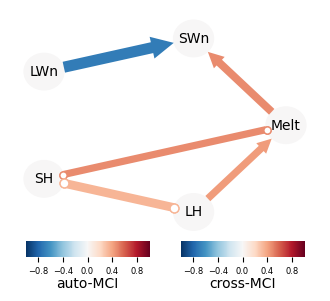

In [17]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [19]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=link_colors,
    graph=link_types,
    var_names=variables,
    link_width=link_widths,
    save_name=home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv',
    digits=5,
)

In [20]:
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv'
pd.read_csv(save_name)

Variable i Variable j  Time lag of i Link type i --- j  Link value  \
0       Melt       Melt              1               -->     0.00000   
1       Melt        SWn              0               -->     0.47083   
2       Melt         SH              0               o-o     0.47527   
3       Melt         LH              0               <--     0.42394   
4        SWn        SWn              1               -->     0.00000   
5        SWn        LWn              0               <--    -0.69877   
6        LWn        LWn              1               -->     0.00000   
7         SH         SH              1               -->     0.00000   
8         SH         LH              0               o-o     0.34212   
9         LH         LH              1               -->     0.00000   

   Link width  
0         0.0  
1        24.0  
2        22.0  
3        22.0  
4         0.0  
5        34.0  
6         0.0  
7         0.0  
8        27.0  
9         0.0

In [21]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'

np.savez(save_name,
         val_matrix=link_colors,
         graph=link_types,
         link_width=link_widths,
         var_names=np.array(variables))

##### without seasonal cycle, max_lag=12, pc_alpha=None

In [22]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 12
pc_alpha = None
remove_seasonal_cycle = True

# Initialize storage
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}

# For auto-MCI: store max self-MCI value and significance across ensemble members
node_self_mci_values = defaultdict(list)       # Max auto-MCI values
node_self_mci_significance = defaultdict(list) # Whether max auto-MCI is significant

for n in range(1, 51):  # Loop over 50 ensemble members
    # Load and prepare data
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    graph = results['graph']
    val_matrix = results['val_matrix']

    # Collect cross-links
    for lag in range(0, max_lag + 1):
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Compute max auto-MCI (across all lags ≥1) and check significance
    for i, var in enumerate(variables):
        # Extract all self-lag values
        self_vals = val_matrix[i, i, 1:]
        max_val = np.max(np.abs(self_vals))   # Max magnitude auto-MCI
        max_lag_idx = np.argmax(np.abs(self_vals)) + 1  # Which lag

        # Check significance: is there a self-link at that lag in the graph?
        is_significant = graph[i, i, max_lag_idx] != '' and graph[i, i, max_lag_idx] != 'o-o'

        node_self_mci_values[var].append(max_val)
        node_self_mci_significance[var].append(is_significant)

In [23]:
# Summarize cross-links as before
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,
                'frequency': freq_count
            }
        else:
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Compute node colors: average max auto-MCI, but set to 0 if not significant in majority of members
summary_nodes = {}
for var in variables:
    # Fraction of members where max auto-MCI is significant
    sig_fraction = np.mean(node_self_mci_significance[var])

    if sig_fraction > 0.5:  # majority significant
        summary_nodes[var] = np.mean(node_self_mci_values[var])
    else:
        summary_nodes[var] = 0.0

In [24]:
# Prepare matrices for cross-links
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

for lag in range(0, max_lag + 1):
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:
            link_types[i, j, lag] = link_type
            link_colors[i, j, lag] = avg_strength
            link_widths[i, j, lag] = frequency

# Node colors: summary_nodes already considers significance
node_colors = [summary_nodes[var] for var in variables]

# Assign node colors to self-link at lag 1 (for plotting)
for i in range(num_vars):
    link_colors[i, i, 1] = node_colors[i]
    link_types[i, i, 1] = '-->'

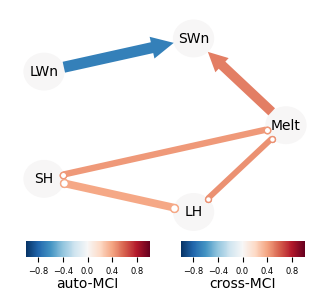

In [25]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [26]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=link_colors,
    graph=link_types,
    var_names=variables,
    link_width=link_widths,
    save_name=home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv',
    digits=5,
)

In [27]:
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv'
pd.read_csv(save_name)

Variable i Variable j  Time lag of i Link type i --- j  Link value  \
0       Melt       Melt              1               -->     0.00000   
1       Melt        SWn              0               -->     0.50900   
2       Melt         SH              0               o-o     0.43103   
3       Melt         LH              0               o-o     0.45444   
4        SWn        SWn              1               -->     0.00000   
5        SWn        LWn              0               <--    -0.68138   
6        LWn        LWn              1               -->     0.00000   
7         SH         SH              1               -->     0.00000   
8         SH         LH              0               o-o     0.38415   
9         LH         LH              1               -->     0.00000   

   Link width  
0         0.0  
1        35.0  
2        23.0  
3        21.0  
4         0.0  
5        40.0  
6         0.0  
7         0.0  
8        28.0  
9         0.0

In [28]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'

np.savez(save_name,
         val_matrix=link_colors,
         graph=link_types,
         link_width=link_widths,
         var_names=np.array(variables))

##### without seasonal cycle, max_lag=6, pc_alpha=0.1

In [12]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 6
pc_alpha = 0.1
remove_seasonal_cycle = True

# Initialize storage
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}

# For auto-MCI: store max self-MCI value and significance across ensemble members
node_self_mci_values = defaultdict(list)       # Max auto-MCI values
node_self_mci_significance = defaultdict(list) # Whether max auto-MCI is significant

for n in range(1, 51):  # Loop over 50 ensemble members
    # Load and prepare data
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    graph = results['graph']
    val_matrix = results['val_matrix']

    # Collect cross-links
    for lag in range(0, max_lag + 1):
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Compute max auto-MCI (across all lags ≥1) and check significance
    for i, var in enumerate(variables):
        # Extract all self-lag values
        self_vals = val_matrix[i, i, 1:]
        max_val = np.max(np.abs(self_vals))   # Max magnitude auto-MCI
        max_lag_idx = np.argmax(np.abs(self_vals)) + 1  # Which lag

        # Check significance: is there a self-link at that lag in the graph?
        is_significant = graph[i, i, max_lag_idx] != '' and graph[i, i, max_lag_idx] != 'o-o'

        node_self_mci_values[var].append(max_val)
        node_self_mci_significance[var].append(is_significant)

In [13]:
# Summarize cross-links as before
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,
                'frequency': freq_count
            }
        else:
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Compute node colors: average max auto-MCI, but set to 0 if not significant in majority of members
summary_nodes = {}
for var in variables:
    # Fraction of members where max auto-MCI is significant
    sig_fraction = np.mean(node_self_mci_significance[var])

    if sig_fraction > 0.5:  # majority significant
        summary_nodes[var] = np.mean(node_self_mci_values[var])
    else:
        summary_nodes[var] = 0.0

In [14]:
# Prepare matrices for cross-links
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

for lag in range(0, max_lag + 1):
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:
            link_types[i, j, lag] = link_type
            link_colors[i, j, lag] = avg_strength
            link_widths[i, j, lag] = frequency

# Node colors: summary_nodes already considers significance
node_colors = [summary_nodes[var] for var in variables]

# Assign node colors to self-link at lag 1 (for plotting)
for i in range(num_vars):
    link_colors[i, i, 1] = node_colors[i]
    link_types[i, i, 1] = '-->'

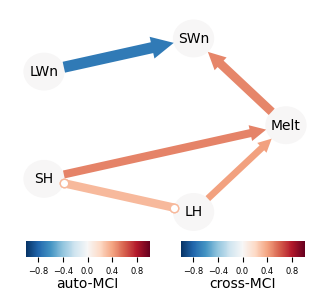

In [15]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [16]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=link_colors,
    graph=link_types,
    var_names=variables,
    link_width=link_widths,
    save_name=home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv',
    digits=5,
)

In [17]:
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv'
pd.read_csv(save_name)

Variable i Variable j  Time lag of i Link type i --- j  Link value  \
0       Melt       Melt              1               -->     0.00000   
1       Melt        SWn              0               -->     0.48853   
2       Melt         SH              0               <--     0.49286   
3       Melt         LH              0               <--     0.40716   
4        SWn        SWn              1               -->     0.00000   
5        SWn        LWn              0               <--    -0.70699   
6        LWn        LWn              1               -->     0.00000   
7         SH         SH              1               -->     0.00000   
8         SH         LH              0               o-o     0.32175   
9         LH         LH              1               -->     0.00000   

   Link width  
0         0.0  
1        26.0  
2        24.0  
3        20.0  
4         0.0  
5        33.0  
6         0.0  
7         0.0  
8        25.0  
9         0.0

In [18]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'

np.savez(save_name,
         val_matrix=link_colors,
         graph=link_types,
         link_width=link_widths,
         var_names=np.array(variables))

##### without seasonal cycle, max_lag=18, pc_alpha=0.1

In [19]:
# Define variables and maximum lag
variables = ['Melt', 'SWn', 'LWn', 'SH', 'LH']
num_vars = len(variables)
max_lag = 18
pc_alpha = 0.1
remove_seasonal_cycle = True

# Initialize storage
link_types_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}
link_strengths_by_lag = {lag: defaultdict(list) for lag in range(0, max_lag + 1)}

# For auto-MCI: store max self-MCI value and significance across ensemble members
node_self_mci_values = defaultdict(list)       # Max auto-MCI values
node_self_mci_significance = defaultdict(list) # Whether max auto-MCI is significant

for n in range(1, 51):  # Loop over 50 ensemble members
    # Load and prepare data
    int_vars = xr.open_dataset(file).sel(ensemble=n).sel(time=slice('2071-01-01','2100-12-31'))
    pcmci = process_prepare_pcmci(int_vars, remove_seasonal_cycle=remove_seasonal_cycle, add_mask=True, mask_period=[5, 6, 7])
    results = pcmci.run_pcmciplus(tau_min=0, tau_max=max_lag, pc_alpha=pc_alpha, contemp_collider_rule='conservative')

    graph = results['graph']
    val_matrix = results['val_matrix']

    # Collect cross-links
    for lag in range(0, max_lag + 1):
        for i in range(num_vars):
            for j in range(num_vars):
                if i != j:
                    link_type = graph[i, j, lag]
                    link_strength = val_matrix[i, j, lag]

                    link_types_by_lag[lag][(i, j)].append(link_type)
                    link_strengths_by_lag[lag][(i, j)].append(link_strength)

    # Compute max auto-MCI (across all lags ≥1) and check significance
    for i, var in enumerate(variables):
        # Extract all self-lag values
        self_vals = val_matrix[i, i, 1:]
        max_val = np.max(np.abs(self_vals))   # Max magnitude auto-MCI
        max_lag_idx = np.argmax(np.abs(self_vals)) + 1  # Which lag

        # Check significance: is there a self-link at that lag in the graph?
        is_significant = graph[i, i, max_lag_idx] != '' and graph[i, i, max_lag_idx] != 'o-o'

        node_self_mci_values[var].append(max_val)
        node_self_mci_significance[var].append(is_significant)

In [20]:
# Summarize cross-links as before
summary_links_by_lag = {lag: {} for lag in range(0, max_lag + 1)}

for lag in range(0, max_lag + 1):
    for (i, j), types in link_types_by_lag[lag].items():
        freq_link_type, freq_count = Counter(types).most_common(1)[0]

        if freq_link_type == '':
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': None,
                'frequency': freq_count
            }
        else:
            avg_strength = np.mean([s for t, s in zip(types, link_strengths_by_lag[lag][(i, j)]) if t == freq_link_type])
            summary_links_by_lag[lag][(i, j)] = {
                'link_type': freq_link_type,
                'avg_strength': avg_strength,
                'frequency': freq_count
            }

# Compute node colors: average max auto-MCI, but set to 0 if not significant in majority of members
summary_nodes = {}
for var in variables:
    # Fraction of members where max auto-MCI is significant
    sig_fraction = np.mean(node_self_mci_significance[var])

    if sig_fraction > 0.5:  # majority significant
        summary_nodes[var] = np.mean(node_self_mci_values[var])
    else:
        summary_nodes[var] = 0.0

In [21]:
# Prepare matrices for cross-links
link_types = np.full((num_vars, num_vars, max_lag + 1), '', dtype='U3')
link_colors = np.zeros((num_vars, num_vars, max_lag + 1))
link_widths = np.zeros((num_vars, num_vars, max_lag + 1))

for lag in range(0, max_lag + 1):
    for (i, j), link_info in summary_links_by_lag[lag].items():
        link_type = link_info['link_type']
        avg_strength = link_info['avg_strength']
        frequency = link_info['frequency']

        if link_type != '' and avg_strength is not None:
            link_types[i, j, lag] = link_type
            link_colors[i, j, lag] = avg_strength
            link_widths[i, j, lag] = frequency

# Node colors: summary_nodes already considers significance
node_colors = [summary_nodes[var] for var in variables]

# Assign node colors to self-link at lag 1 (for plotting)
for i in range(num_vars):
    link_colors[i, i, 1] = node_colors[i]
    link_types[i, i, 1] = '-->'

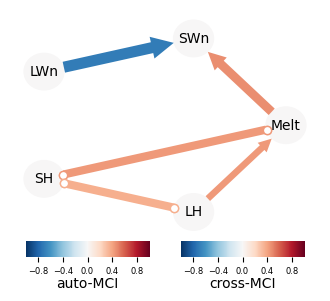

In [22]:
## Plot the summary causal graph

# Plot the summary causal graph with tp.plot_graph
tp.plot_graph(
    val_matrix=link_colors,  # Use the color matrix across all lags, including lag=0
    graph=link_types,  # Use the most frequent link type for each lag, including lag=0
    var_names=variables,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    link_width=link_widths,  # Use the width matrix across all lags, including lag=0
    node_size=0.4,
    figsize=(4, 3),
    #lagged_links=True  # This setting allows multiple links for different lags to be displayed
);

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/LENS2/'
plt.savefig(plot_dir+'graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.png', dpi=300, bbox_inches='tight', facecolor='w', transparent=False)

In [23]:
#The links can also be exported to a csv file:
tp.write_csv(
    val_matrix=link_colors,
    graph=link_types,
    var_names=variables,
    link_width=link_widths,
    save_name=home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv',
    digits=5,
)

In [24]:
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig.csv'
pd.read_csv(save_name)

Variable i Variable j  Time lag of i Link type i --- j  Link value  \
0       Melt       Melt              1               -->     0.00000   
1       Melt        SWn              0               -->     0.46360   
2       Melt         SH              0               o-o     0.43147   
3       Melt         LH              0               <--     0.43322   
4        SWn        SWn              1               -->     0.00000   
5        SWn        LWn              0               <--    -0.70223   
6        LWn        LWn              1               -->     0.00000   
7         SH         SH              1               -->     0.00000   
8         SH         LH              0               o-o     0.36523   
9         LH         LH              1               -->     0.00000   

   Link width  
0         0.0  
1        27.0  
2        25.0  
3        20.0  
4         0.0  
5        34.0  
6         0.0  
7         0.0  
8        25.0  
9         0.0

In [25]:
# Save for plotting (since the format saved by tp.write_csv is hard to use)
save_name = home_dir+'2023-GrIS-melt-causality/data/LENS2/graph_summary_mostfreq_pcmciplus_melt_SEB_noGHF_F09BSSP370_realJJA_GrIS_ablation_noseasonality_LENS2_2071_2100_conservative_nofdrc_robustparcorr_taumax'+str(max_lag)+'_alpha'+str(pc_alpha)+'_sig_forplot.npz'

np.savez(save_name,
         val_matrix=link_colors,
         graph=link_types,
         link_width=link_widths,
         var_names=np.array(variables))

### Investigating data dependencies and lag functions

To investigate the type of dependencies, we use the ``plot_scatterplots`` and  ``plot_densityplots`` functions to see whether the dependencies are really linear. With the argument ``matrix_lags`` set to a ``(N, N)`` integer numpy array you can choose which lag to use for every pair of variables. Here it is left ``None`` implying lag zero.

In [42]:
parcorr = ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe, 
    cond_ind_test=parcorr,
    verbosity=1)
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
#correlations = pcmci.run_bivci(tau_max=20, val_only=True)['val_matrix']


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 20


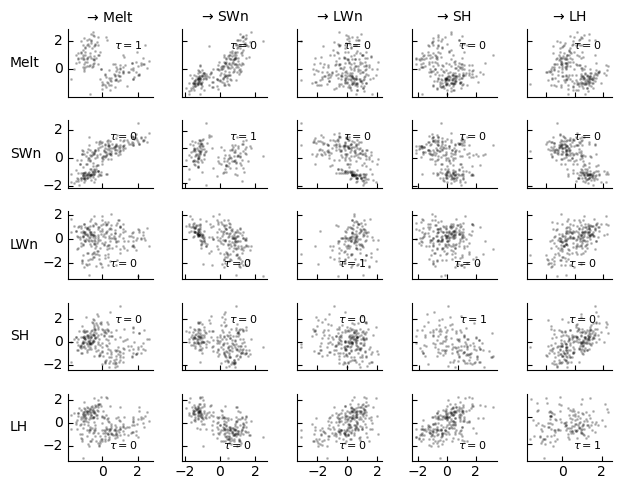

In [31]:
matrix_lags = None #np.argmax(np.abs(correlations), axis=2)
#matrix_lags = np.argmax(np.abs(correlations), axis=2)

# Standardize data to make it comparable
data_smooth_here = deepcopy(data_smooth)
mean, std = pp.weighted_avg_and_std(data_smooth_here, axis=0, weights=(mask==False))
data_smooth_here -= mean
data_smooth_here /= std

dataframe_here = pp.DataFrame(data_smooth_here, mask=mask, var_names=var_names)

tp.plot_scatterplots(dataframe=dataframe_here, add_scatterplot_args={'matrix_lags':matrix_lags}); plt.show()

(The diagonal panels show the lag-zero scatter plots of variables with itself here.)

Next, we investigate kernel density estimates of the joint and marginal (diagonal panels) densities.

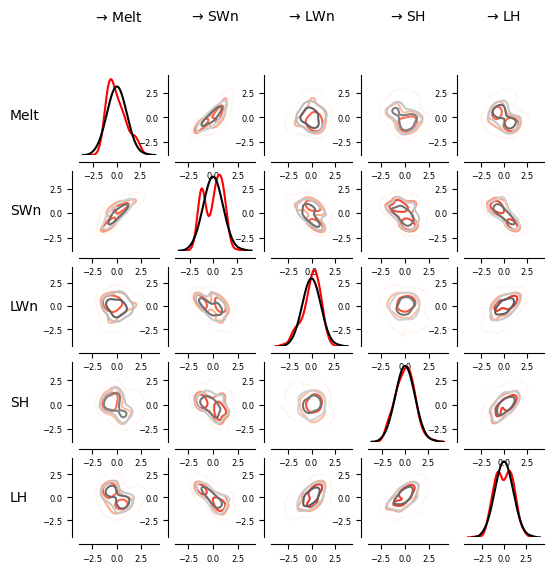

In [32]:
matrix = tp.setup_density_matrix(N=N, 
        var_names=dataframe_here.var_names, **{
        'figsize':(6, 6), 
        'tick_label_size':6,
        'label_space_left':0.18})

# Now transform data to normal marginals
data_normal = deepcopy(data_smooth)
data_normal = pp.trafo2normal(data_smooth, mask=mask)
dataframe_normal = pp.DataFrame(data_normal, mask=mask, var_names=var_names)

matrix.add_densityplot(dataframe=dataframe_here, 
    matrix_lags=matrix_lags, label_color='red', 
    snskdeplot_args = {'cmap':'Reds', 'alpha':1., 'levels':4})

matrix.add_densityplot(dataframe=dataframe_normal, 
    matrix_lags=matrix_lags, label_color='black', 
    snskdeplot_args = {'cmap':'Greys', 'alpha':1., 'levels':4})

Since in our toy model the dependencies appear reasonably linear and the distributions Gaussian, we use the ``ParCorr`` conditional independence test implementing linear partial correlation. With ``significance='analytic'`` the null distribution is assumed to be Student's $t$. 

Next, it's a good idea to plot the lagged unconditional dependencies, e.g., the lagged correlations using the ``ParCorr`` class. This can help to identify which maximal time lag ``tau_max`` to choose in the causal algorithm.
 
To this end we initialize the ``PCMCI`` method with  ``dataframe``, and ``ParCorr`` as a ``cond_ind_test``. 

In [33]:
robustparcorr = RobustParCorr(significance='analytic', mask_type='y')
pcmci = PCMCI(
    dataframe=dataframe,
    cond_ind_test=robustparcorr,
    verbosity=1)

Before running PCMCIplus, it's a good idea to run and plot the function ``run_bivci``, which implements a bivariate, lagged conditional independence test (similar to bivariate Granger causality, but lag-specific). This can help to identify which maximal time lag ``tau_max`` to choose. Another option would be to plot ``get_lagged_dependencies``, but large autocorrelation will inflate lag peaks (see https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-13-00159.1) and ``run_bivci`` at least conditions out some part of the autocorrelation.


##
## Estimating lagged dependencies 
##

Parameters:

independence test = robust_par_corr
tau_min = 0
tau_max = 20


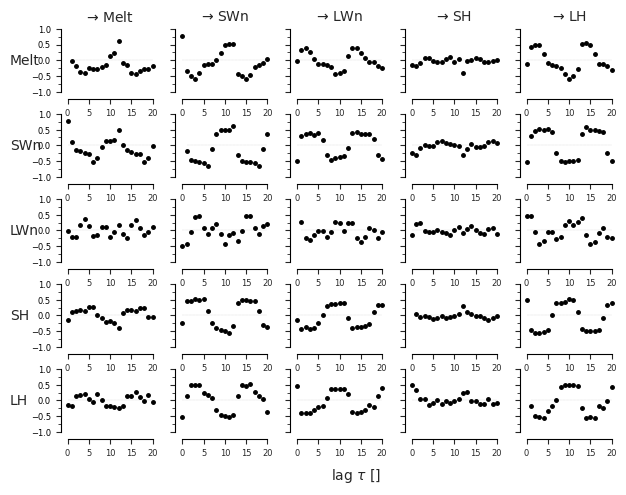

In [34]:
correlations = pcmci.get_lagged_dependencies(tau_max=20, val_only=True)['val_matrix']
#correlations = pcmci.run_bivci(tau_max=20, val_only=True)['val_matrix']
lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                    'x_base':5, 'y_base':.5}); plt.show()

## Causal effect analysis

The causal question is now about causal effect estimation and mediation. This quantification requires qualitative knowledge about cause-and-effect relationships in form of the causal time series graph. Causal discovery, that is, to learn the causal graph from the data, is challenging for such short sample sizes, so domain knowledge is used to come up with the qualitative feedback graph shown below with the time lags roughly based on the wind velocities in Gushchina et al. 2020 (see paper). 

The process graph (sometimes also referred to as summary graph) on the left aggregates the time series graph which explicitely depicts the time-dependent structure. Since atmospheric processes are fast, contemporaneous causal effects are assumed (that is, causal influences on a time scale below data's time resolution of 2 months). However, for simplicity, it is assumed that there are no contemporaneous causal cycles (that is, if, for example, WPAC$_t$ had a causal influence on CPAC$_t$, then CPAC$_t$ could not have a causal influence on WPAC$_t$, and vice versa).

See the [causal effect tutorial](https://github.com/jakobrunge/tigramite/blob/master/tutorials/causal_effect_estimation/tigramite_tutorial_general_causal_effect_analysis.ipynb) for how to specify graphs. 

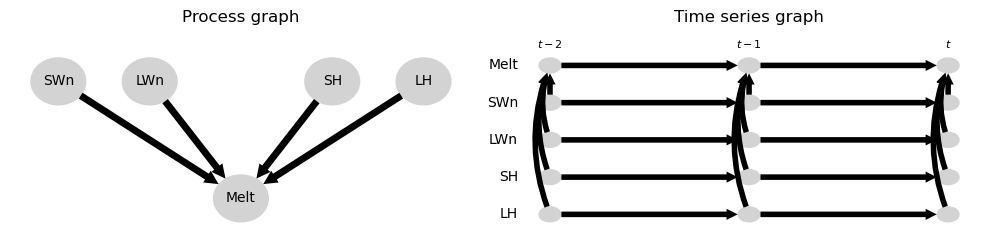

In [21]:
# Causal effect estimation
# Graph has shape (N, N, tau_max + 1)
graph = np.array([
        [['', '-->', ''],
        ['<--', '', ''],
        ['<--', '', ''],
        ['<--', '', ''],
        ['<--', '', '']],

       [['-->', '', ''],
        ['', '-->', ''],
        ['', '', ''],
        ['', '', ''],
        ['', '', '']],

       [['-->', '', ''],
        ['', '', ''],
        ['', '-->', ''],
        ['', '', ''],
        ['', '', '']],

       [['-->', '', ''],
        ['', '', ''],
        ['', '', ''],
        ['', '-->', ''],
        ['', '', '']],

       [['-->', '', ''],
        ['', '', ''],
        ['', '', ''],
        ['', '', ''],
        ['', '-->', '']]], dtype='<U3')

# Positions of nodes for process graph
node_pos =  {
            'y': np.array([0., 0.5, 0.5, 0.5, 0.5]),
            'x': np.array([1., 0., 0.5, 1.5, 2.])
            }

# Show both graphs next to each other
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 2.5))

tp.plot_graph(
    fig_ax = (fig, axes[0]),
    graph = graph,
    node_pos=node_pos,
    arrow_linewidth=5,
    node_size=0.2,
    node_aspect=1.5,
    var_names=var_names,
    tick_label_size=6,
    )
axes[0].set_title('Process graph', pad=20)

tp.plot_time_series_graph(
    fig_ax = (fig, axes[1]),
    graph = graph,
    var_names=var_names,
    )
axes[1].set_title('Time series graph', pad=20)

fig.tight_layout()

#plt.savefig('plot/graph_tgraph_melt_SEB_define.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

One can argue about which graph to assume here. For example, one may integrate hidden confounders, that is, unobserved variables which causally influence two observed variables (see the biogeoscience example). Here, due to the above pre-processing steps for removing long-terms trend and seasonal cycles, as well as restricting to time periods across which stationarity can be assumed, one might reasonably assume the absence of hidden confounding. A more thorough analysis could, for example, in addition consider interdependencies with sea-surface temperature as a possible source of hidden confounding. The strength of causal inference lies in transparently laying out such assumptions.

### Wright's path-method for causal effect estimation

To this end, since there are no unobserved nodes assumed, we can use Wright's path-method functionality in the ``CausalEffects``-class. We will wrap the method including the bootstrap confidence interval estimation into a fuction.

In [31]:
def get_path_effect(graph, X, Y, mediation=None, conf_lev=0.9):
    causal_effects = CausalEffects(graph, graph_type='stationary_dag', 
                                    X=X, Y=Y, 
                                   S=None, 
                                   verbosity=0)
    
    dox_vals = np.linspace(0., 1., 2)

    # Fit causal effect model from observational data
    causal_effects.fit_wright_effect(
        dataframe=dataframe, 
        mask_type='y',
        mediation=mediation, #'direct',
        method = 'parents',
        data_transform=data_transform, #sklearn.preprocessing.StandardScaler(),
        )

    # Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
    intervention_data = np.repeat(dox_vals.reshape(len(dox_vals), 1), axis=1, repeats=len(X))
    pred_Y = causal_effects.predict_wright_effect( 
            intervention_data=intervention_data)

    # Fit causal effect model from observational data
    causal_effects.fit_bootstrap_of(
        method='fit_wright_effect',
        method_args={'dataframe':dataframe,  
        'mask_type':'y',
        'mediation':mediation, #'direct',
        'data_transform':data_transform,
        },
        seed=42
        )

    # Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
    intervention_data = np.repeat(dox_vals.reshape(len(dox_vals), 1), axis=1, repeats=len(X))
    conf = causal_effects.predict_bootstrap_of(
        method='predict_wright_effect',
        method_args={'intervention_data':intervention_data},
        conf_lev=conf_lev)

    print("Wright's path effect    = %.2f [%.2f, %.2f]"
                %(pred_Y[1], conf[0,1], conf[1,1]))


In [24]:
## Ablation zone time series, without GHF
# Optional data transform
data_transform = None  # sklearn.preprocessing.StandardScaler()

get_path_effect(graph, X=[(1,0)], Y=[(0,0)], mediation=None, conf_lev=0.9)
get_path_effect(graph, X=[(2,0)], Y=[(0,0)], mediation=None, conf_lev=0.9)
get_path_effect(graph, X=[(3,0)], Y=[(0,0)], mediation=None, conf_lev=0.9)
get_path_effect(graph, X=[(4,0)], Y=[(0,0)], mediation=None, conf_lev=0.9)

Wright's path effect    = 0.89 [0.86, 0.92]
Wright's path effect    = 0.45 [0.42, 0.50]
Wright's path effect    = 0.42 [0.40, 0.46]
Wright's path effect    = 0.16 [0.14, 0.19]


### (Optimal) adjustment for causal effect estimation

This will use the ``CausalEffects`` class of Tigramite, see the [corresponding tutorial]().

In [25]:
def get_adjustment_effect(graph, X, Y, conf_lev=0.9):

    # Initialize class with stationary directed acyclic graph (DAG) defined above
    causal_effects = CausalEffects(graph, graph_type='stationary_dag', 
                                        X=X, Y=Y, 
                                       S=None, # S could be a modulating variable to estimate conditional causal effects
                                       verbosity=0)

    print("X = %s -----> Y = %s" % (str([(var_names[var[0]], var[1]) for var in X]), str([(var_names[var[0]], var[1]) for var in Y])))

    # Get optimal adjustment set
    opt = causal_effects.get_optimal_set()

    if opt is False: print("NOT IDENTIFIABLE!")
    print("Oset = ", [(var_names[v[0]], v[1]) for v in opt])
    # Optionally check whether here an optimal adjustment set exists 
    # in the sense that it has the smallest asymptotic variance among all adjustment sets (see [Runge 2021](https://arxiv.org/abs/2102.10324))
    # print("Optimality = %s" %str(causal_effects.check_optimality()))

    # Color nodes
    special_nodes = {}
    for node in opt:
        special_nodes[node] = 'orange'
    for node in causal_effects.M:
        special_nodes[node] = 'lightblue'
    for node in causal_effects.X:
        special_nodes[node] = 'red'
    for node in causal_effects.Y:
        special_nodes[node] = 'blue'

#    fig, ax = tp.plot_time_series_graph(
#            graph = graph,
#            special_nodes=special_nodes,
#            var_names=var_names,
#            figsize=(3, 2.5),
#            )
#    plt.tight_layout()

    # Optional data transform
    data_transform = None  # sklearn.preprocessing.StandardScaler()

    # Fit causal effect model from observational data
    causal_effects.fit_total_effect(
        dataframe=dataframe, 
        mask_type='y',
        estimator=LinearRegression(),
        data_transform=data_transform,
        )

    # Fit bootstrap causal effect model
    causal_effects.fit_bootstrap_of(
        method='fit_total_effect',
        method_args={'dataframe':dataframe,  
        'mask_type':'y',
        'estimator':LinearRegression(),
        'data_transform':data_transform,
        },
        seed=4
        )

    # Define interventions
    dox_vals = np.linspace(0., 1., 2)

    # Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
    intervention_data = np.repeat(dox_vals.reshape(len(dox_vals), 1), axis=1, repeats=len(X))
    pred_Y = causal_effects.predict_total_effect( 
            intervention_data=intervention_data)

    # Bootstrap: Predict effect of interventions do(X=0.), ..., do(X=1.) in one go
    intervention_data = np.repeat(dox_vals.reshape(len(dox_vals), 1), axis=1, repeats=len(X))
    conf = causal_effects.predict_bootstrap_of(
        method='predict_total_effect',
        method_args={'intervention_data':intervention_data},
        conf_lev=conf_lev)

    print("Total effect via adjustment = %.2f [%.2f, %.2f]"
            %(pred_Y[1]-pred_Y[0], conf[0,1]-conf[0,0], conf[1,1]-conf[1,0])) 

The mediator is shown in light blue. The conditioning set $\mathbf{Z}$ blocks non-causal confounding of $X$ and $Y$ by $\text{CPAC}_{t-1}$ as well as by further lagged confounders.

We now fit and predict the total effect of X on Y using the ``fit_total_effect`` function and obtain an uncertainty estimate using the ``fit_bootstrap_of`` function. Here setting the interventions to 0 and 1 and computing the difference of the corresponding predictions yields a causal effect that corresponds to the linear regression coefficient. Note that due to the anomalization performed above, the data is approximately standardized.

In [26]:
get_adjustment_effect(graph, X=[(1,0)], Y=[(0,0)], conf_lev=0.9)
get_adjustment_effect(graph, X=[(2,0)], Y=[(0,0)], conf_lev=0.9)
get_adjustment_effect(graph, X=[(3,0)], Y=[(0,0)], conf_lev=0.9)
get_adjustment_effect(graph, X=[(4,0)], Y=[(0,0)], conf_lev=0.9)

X = [('SWn', 0)] -----> Y = [('Melt', 0)]
Oset =  [('LH', 0), ('LWn', 0), ('Melt', -1), ('SH', 0)]
Total effect via adjustment = 0.89 [0.89, 0.91]
X = [('LWn', 0)] -----> Y = [('Melt', 0)]
Oset =  [('SWn', 0), ('LH', 0), ('Melt', -1), ('SH', 0)]
Total effect via adjustment = 0.45 [0.44, 0.45]
X = [('SH', 0)] -----> Y = [('Melt', 0)]
Oset =  [('SWn', 0), ('LH', 0), ('LWn', 0), ('Melt', -1)]
Total effect via adjustment = 0.42 [0.42, 0.43]
X = [('LH', 0)] -----> Y = [('Melt', 0)]
Oset =  [('SWn', 0), ('LWn', 0), ('Melt', -1), ('SH', 0)]
Total effect via adjustment = 0.16 [0.16, 0.15]


## Bootstrap

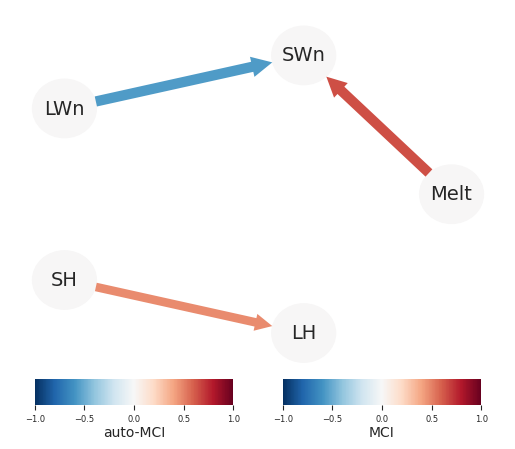

In [40]:
# alpha = 0.01
pc_alpha_bootstrap = 0.01
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus',
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plot_dir = home_dir+'2023-GrIS-melt-causality/plot/CESM2_F09/clean_seasonality_mask/withoutism/'
plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_SEB_noGHF_F09BHIST_realJJA_GrIS_ablation_seasonality_LENS2'+num+'_conservative_nofdrc_robustparcorr_taumax15_alpha001_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

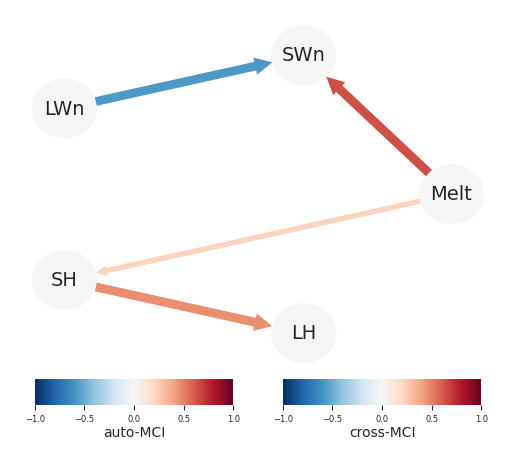

In [41]:
# alpha = 0.025
pc_alpha_bootstrap = 0.025
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_SEB_noGHF_F09BHIST_realJJA_GrIS_ablation_seasonality_LENS2'+num+'_conservative_nofdrc_robustparcorr_taumax15_alpha0025_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

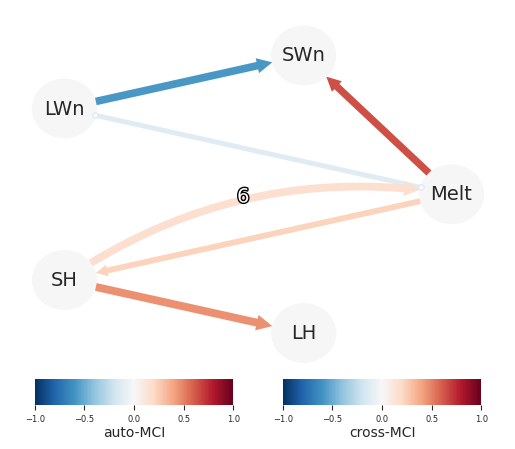

In [42]:
# alpha = 0.05
pc_alpha_bootstrap = 0.05
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_SEB_noGHF_F09BHIST_realJJA_GrIS_ablation_seasonality_LENS2'+num+'_conservative_nofdrc_robustparcorr_taumax15_alpha005_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

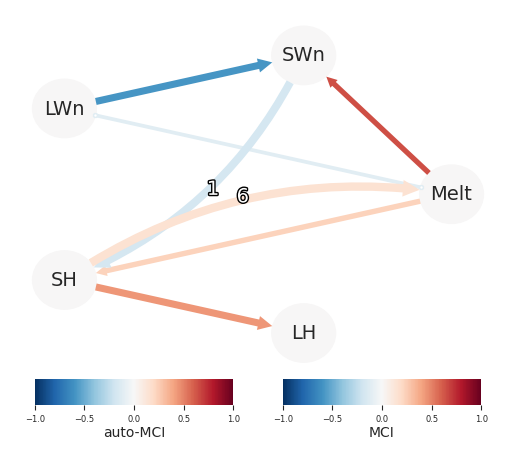

In [43]:
# alpha = 0.1
pc_alpha_bootstrap = 0.1
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    ); 

plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_SEB_noGHF_F09BHIST_realJJA_GrIS_ablation_seasonality_LENS2'+num+'_conservative_nofdrc_robustparcorr_taumax15_alpha01_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)

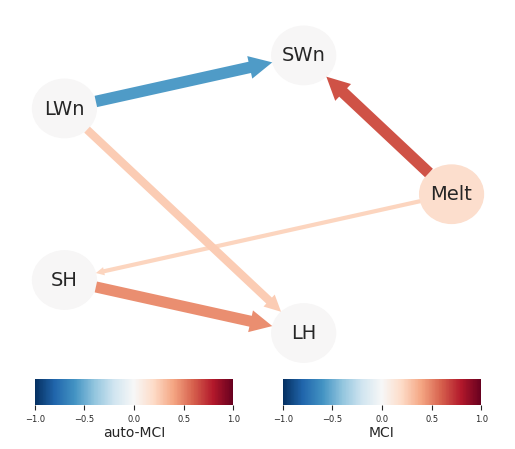

In [44]:
# alpha = None
pc_alpha_bootstrap = None
boot_samples = 100
tau_max = 15

# The block-length of the bootstrap can optionally be used to better deal with autocorrelation, 
# but its effect was not yet evaluated.
boot_blocklength = 1

## Create PCMCI object to call run_bootstrap_of
pcmci = PCMCI(dataframe=dataframe,
        cond_ind_test=robustparcorr,
        verbosity=0,
        )

# Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
results = pcmci.run_bootstrap_of(
        method='run_pcmciplus', 
        method_args={'tau_max':tau_max, 'pc_alpha':pc_alpha_bootstrap, 'contemp_collider_rule':'conservative'}, 
        boot_samples=boot_samples,
        boot_blocklength=boot_blocklength,
        seed=123)

# Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
boot_linkfreq = results['summary_results']['link_frequency']
boot_graph = results['summary_results']['most_frequent_links']
val_mat = results['summary_results']['val_matrix_mean']

# Plot
tp.plot_graph(
    graph = boot_graph,
    val_matrix= val_mat,
    link_width = boot_linkfreq,
    var_names=dataframe.var_names,
    node_size=0.4,
    node_label_size=14,
    node_ticks=0.5,
    edge_ticks=0.5,
    link_label_fontsize=14,
    arrow_linewidth=10.0,
    );

plt.savefig(plot_dir+'graph_pcmciplus_bootstrap_melt_SEB_noGHF_F09BHIST_realJJA_GrIS_ablation_seasonality_LENS2'+num+'_conservative_nofdrc_robustparcorr_taumax15_alphaNone_clean.png', dpi = 300, bbox_inches = 'tight', facecolor='w', transparent = False)